In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Introduction

Every year, there are over 85 million taxi rides in New York City, criss-crossing the city in a network of distinctive yellow cabs. The taxi system is essential for tourists and New Yorkers alike, getting them to where they need to go and keeping the city that never sleeps running. But what exactly are the factors that drive taxi ridership in the first place? And are there patterns in where people go, when, and why?

This data set aims to answer these questions and more regarding factors and trends in New York City taxi rides, with special attention to correlations between taxi ridership and weather, time of day, and location. We began by creating a dataset using data on taxi ridership and weather gathered from other sources. We then used a multitude of data analyses and visualizations to search for possible patterns and learn more about taxi ridership, in the hopes that our research would be able to contribute to discussion on how the system may be improved.

Our general findings were as follows:
- Taxi ridership has a strong negative correlation to maximum and average temperature of the day, suggesting that on warm days, people may be using other forms of transportation or staying inside altogether.
- Predictably, taxi ridership is higher in the day time hours than the night time hours, with a peak roughly between 4pm and 8pm. However, this trend varies when looking closer at weekends compared to weekdays.
- Regarding location, we took a closer look at taxi ridership in Manhattan, ostensibly the busiest part of the city, and how several factors varied depending on pick-up and drop-off locations. We discovered that, on average, the taxi rides that occurred Downtown had a greater distance, fare amount, and speed compared to rides elsewhere.

In addition to these findings, we noticed several other points of interest related not only to taxi rides, but their riders as well, such as a major spike in ridership around 2am in Downtown Manhattan that may be attributed to local nightlife patterns. Indeed, our exploration of this dataset sheds light on both the trends of the taxi network and the lives of the people who hail them, trends that may be valuable to achieving a deeper understanding of the workings of New York City as a whole.

# Data Description

In [2]:
df=pd.read_csv("nyc_taxis_weather_jantoaug19s.csv")
df.head()

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,RatecodeID,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,...,date,maxtemp,mintemp,avetemp,departuretemp,hdd,cdd,precipitation,newsnow,snowdepth
0,2019-01-17 18:30:40,2019-01-17 18:35:20,162,233,1.0,0.0,1.0,5.0,0.3,0.5,...,1/17/19,33.0,24.0,28.5,-3.7,36.0,0.0,0.00,0.0,0.0
1,2019-01-07 20:45:41,2019-01-07 21:10:25,186,75,1.0,0.0,0.5,19.5,0.3,0.5,...,1/7/19,34.0,25.0,29.5,-3.2,35.0,0.0,0.00,0.0,0.0
2,2019-01-29 10:00:49,2019-01-29 10:07:37,236,237,1.0,0.0,0.0,6.0,0.3,0.5,...,1/29/19,43.0,25.0,34.0,1.1,31.0,0.0,0.23,0.0,0.0
3,2019-01-10 05:54:57,2019-01-10 06:12:44,211,138,1.0,0.0,0.5,29.0,0.3,0.5,...,1/10/19,34.0,28.0,31.0,-1.4,34.0,0.0,0.00,0.0,0.0
4,2019-01-24 08:59:00,2019-01-24 09:12:27,233,170,1.0,0.0,0.0,9.0,0.3,0.5,...,1/24/19,59.0,35.0,47.0,14.5,18.0,0.0,1.33,0.0,0.0


In [3]:
df["pickup_datetime"]=pd.to_datetime(df['pickup_datetime'])
df["dropoff_datetime"]=pd.to_datetime(df['dropoff_datetime'])
df["date"]=pd.to_datetime(df['date'])

In [4]:
df.describe()

,PULocationID,DOLocationID,RatecodeID,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,...,trip_duration_mins,maxtemp,mintemp,avetemp,departuretemp,hdd,cdd,precipitation,newsnow,snowdepth
count,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000,...,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000,112477.000000
mean,162.708989,161.251278,1.052757,1.972432,1.069508,13.069175,0.299957,0.498031,1.571930,1.284280,...,17.901958,62.709229,48.408083,55.558656,0.568431,13.058225,3.868471,0.154173,0.059398,0.074646
std,65.930004,70.204550,0.669910,1.020093,1.237574,11.634605,0.003578,0.031317,1.223864,0.465239,...,71.229773,19.321750,18.012927,18.503375,6.783016,14.375019,5.924048,0.315308,0.374370,0.418563
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.020000,14.000000,2.000000,9.000000,-24.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,114.000000,107.000000,1.000000,2.500000,0.000000,6.500000,0.300000,0.500000,1.000000,1.000000,...,6.680000,46.000000,34.000000,40.500000,-3.400000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,162.000000,162.000000,1.000000,2.500000,0.500000,9.500000,0.300000,0.500000,1.000000,1.000000,...,11.130000,66.000000,50.000000,56.500000,0.900000,8.000000,0.000000,0.000000,0.000000,0.000000
75%,233.000000,233.000000,1.000000,2.500000,2.500000,14.500000,0.300000,0.500000,2.000000,2.000000,...,18.200000,80.000000,65.000000,72.000000,4.600000,24.000000,7.000000,0.100000,0.000000,0.000000
max,265.000000,265.000000,99.000000,2.500000,17.500000,314.000000,0.300000,0.500000,6.000000,4.000000,...,1439.020000,95.000000,82.000000,88.500000,20.800000,56.000000,24.000000,1.820000,4.000000,4.000000


In [5]:
df.dtypes

pickup_datetime          datetime64[ns]
dropoff_datetime         datetime64[ns]
PULocationID                      int64
DOLocationID                      int64
RatecodeID                      float64
congestion_surcharge            float64
extra                           float64
fare_amount                     float64
improvement_surcharge           float64
mta_tax                         float64
passenger_count                 float64
payment_type                    float64
store_and_fwd_flag               object
tip_amount                      float64
tolls_amount                    float64
total_amount                    float64
trip_distance                   float64
pickup_dayofweek                  int64
trip_duration_mins              float64
date                     datetime64[ns]
maxtemp                         float64
mintemp                         float64
avetemp                         float64
departuretemp                   float64
hdd                             float64


# Data Analysis and Evaluation of Significance

# 2. Uncovering General Trends in NYC Taxi Ridership

In many ways, the thousands of yellow taxis that fill the NYC streets every minute carry in them the pulse of the world's greatest city. We would first like to put a finger on this pulse by exploring general trends in our taxi ridership dataset.

To that end, we will look at time series trends, along with measures of central tendency for a variety of variables. 

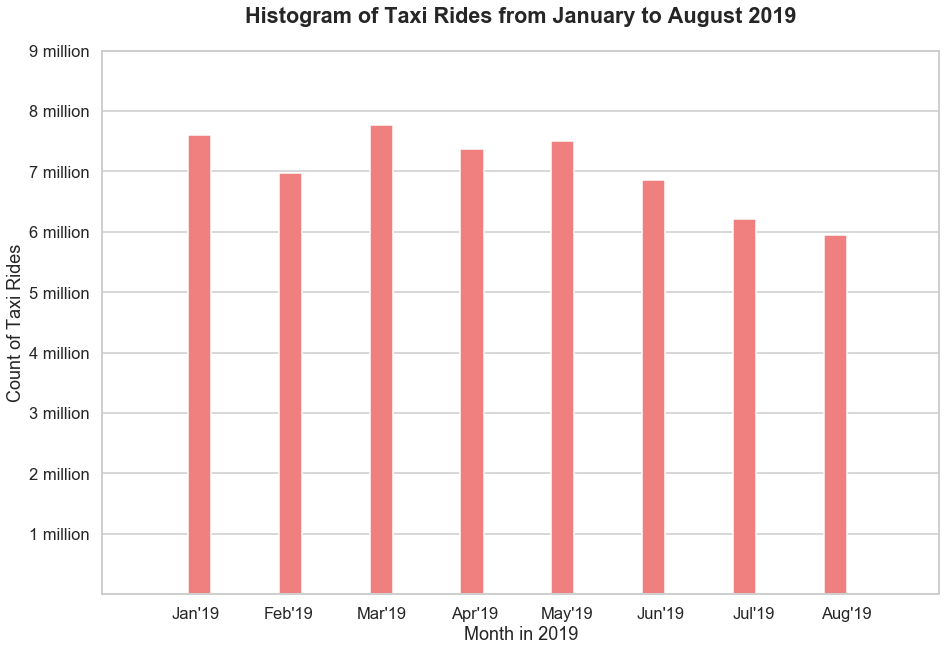

In [6]:
plt.figure(figsize=(15,10))
sns.set(context="talk", style="whitegrid", palette="bright")
g=sns.distplot(df["pickup_datetime"].dt.month, kde=False, hist_kws={"width":0.25,"align":"left","color":"lightcoral", 'alpha': 1})
g.xaxis.grid(b=False)
plt.xlim(0,9)
g.set_xticklabels(["","Jan'19","Feb'19","Mar'19","Apr'19","May'19","Jun'19","Jul'19","Aug'19"])
plt.yticks(g.get_yticks(), (g.get_yticks() * 1/0.002).astype(int))
g.set_yticklabels(["","1 million","2 million","3 million","4 million","5 million","6 million","7 million","8 million","9 million"])
plt.xlabel("Month in 2019")
plt.ylabel("Count of Taxi Rides")
plt.title("Histogram of Taxi Rides from January to August 2019", fontweight="bold", fontsize="large", y=1.04)
plt.show()

From January to August 2019, there was an average of 7.03 million taxi rides in NYC each month. There is a sizable variation in monthly taxi ridership, with March taxi rides outnumbering those in August by 1.81 million. 

Overall, there is a noticeable trend, possibly due to changes in weather or seasonal behavior, that monthly taxi ridership falls as the year heads into the warmer months. Due to the high volume of taxi rides in January, however, we can reasonably assume that monthly taxi ridership will climb up again some time in the months between September and December, as the seasons become cold once again.

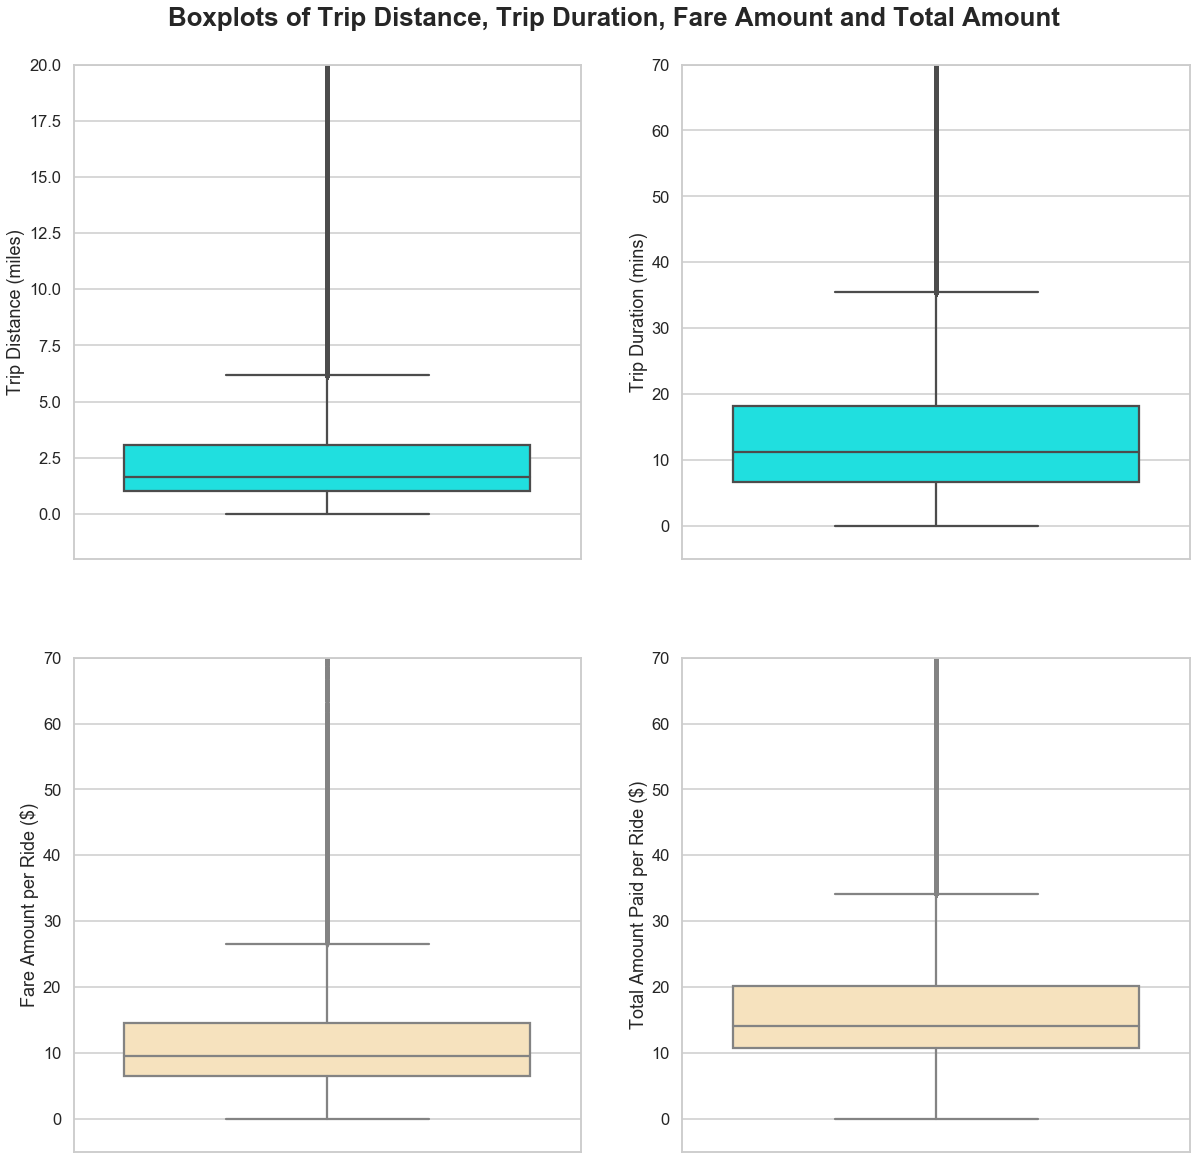

In [7]:
fig,axes=plt.subplots(2,2, figsize=(20,20))

a=sns.boxplot(y=df['trip_distance'], ax=axes[0,0],color="cyan").set(ylabel='Trip Distance (miles)')
axes[0,0].set(ylim=(-2, 20))

sns.boxplot(y=df['trip_duration_mins'], ax=axes[0,1],color="cyan").set(ylabel='Trip Duration (mins)')
axes[0,1].set(ylim=(-5, 70))


sns.boxplot(y=df['fare_amount'], ax=axes[1,0],color="moccasin").set(ylabel='Fare Amount per Ride ($)')
axes[1,0].set(ylim=(-5, 70))

sns.boxplot(y=df['total_amount'], ax=axes[1,1],color="moccasin").set(ylabel='Total Amount Paid per Ride ($)')
axes[1,1].set(ylim=(-5, 70))

fig.suptitle('Boxplots of Trip Distance, Trip Duration, Fare Amount and Total Amount', fontsize="x-large", fontweight="bold", y=0.92)
plt.show()

According to the top left boxplot, the vast majority of NYC taxi rides are short hops, with a median trip distance of just 1.63 miles and a narrow interquartile range of 2.1 miles. This is expected for a dense city like NYC where spaces for living, working, dining and recreation are in close proximity and do not require long-distance taxi rides to travel between. 

As for trip duration (depicted in the top right boxplot), the median stands at 11.1 minutes per ride. There is much more variation in trip durations, with a wide interquartile range of 17.2 minutes. This is unsurprising given the large variability in NYC traffic conditions. The median trip speed (which we calculated by dividing the distance variable over duration) is an incredibly slow 9.95 miles per hour. Perhaps some of these taxi commuters should consider using the subway!

For fare amount and total amount, there are a sizable number of outliers (such as fare amounts exceeding \\$300), that may attributed to the rare case of long distance travel upstate or perhaps an emergency ride to the airport to catch a flight. Thus it is justifiable to focus on the median instead of the mean in this case. The median fare amount is \\$9.50, while the median total amount (which includes fares, tolls and tips) is \\$14.16. These are pretty expected rates for a taxi ride in NYC, given the short distance of the average ride. 

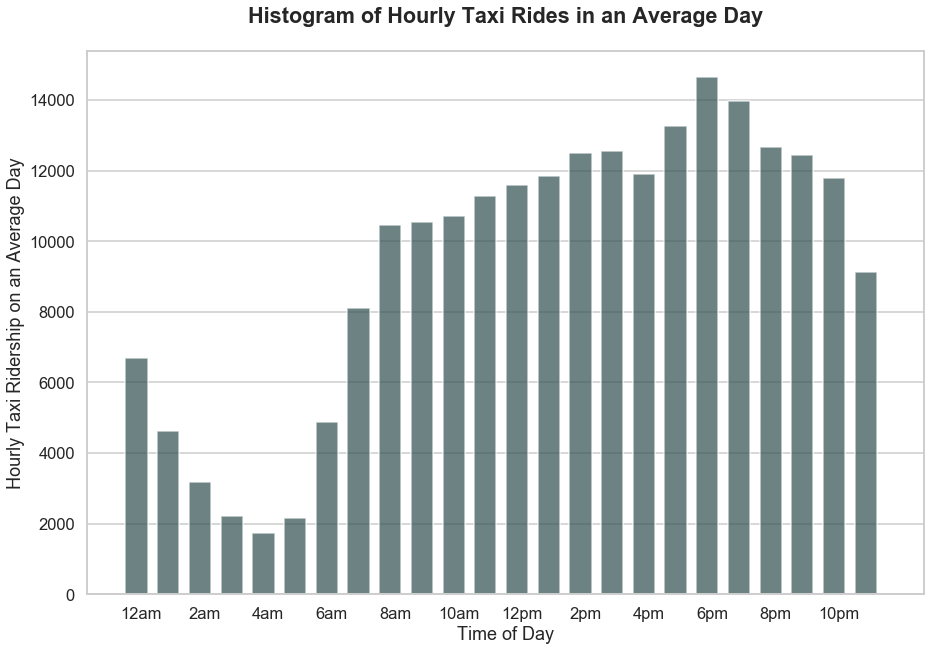

In [8]:
#scaling df to a daily time frame: dividing by 0.002 as we sampled 0.002 of dataset, and dividing by 242 as there are 242 days in our sample
scaled_daily_df = pd.concat([df]*round(1/0.002/242))

plt.figure(figsize=(15,10))
g=sns.distplot(pd.to_datetime(scaled_daily_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,1)-0.5, kde=False, hist_kws={"width":0.7, "color":"darkslategray", 'alpha': 0.7})
g.xaxis.grid(b=False)
plt.xticks(np.arange(0,26, 2), labels=["12am","2am","4am","6am","8am","10am","12pm","2pm","4pm","6pm","8pm","10pm"])
plt.xlabel("Time of Day")
plt.ylabel("Hourly Taxi Ridership on an Average Day")
plt.title("Histogram of Hourly Taxi Rides in an Average Day", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Even in the city that never sleeps, there is enormous variation in hourly taxi ridership throughout the day, with 8 times more rides at 6pm than 4am. As daylight breaks, there is a sharp jump in taxi rides from 6am onwards, as people begin their morning commutes to work. Hourly taxi ridership doubles from 4,870 at 6-7am to 10,730 at 10-11am. Hourly taxi ridership remains high throughout the day, climbing through the lunchtime hours and afternoon, before reaching its daily peak of 14,660 at 6-7pm, when the office crowd gets off work. Hourly ridership remains high until 11pm, after which there is a sharp dropoff in rides, with the least amount of rides being taken at 4am.

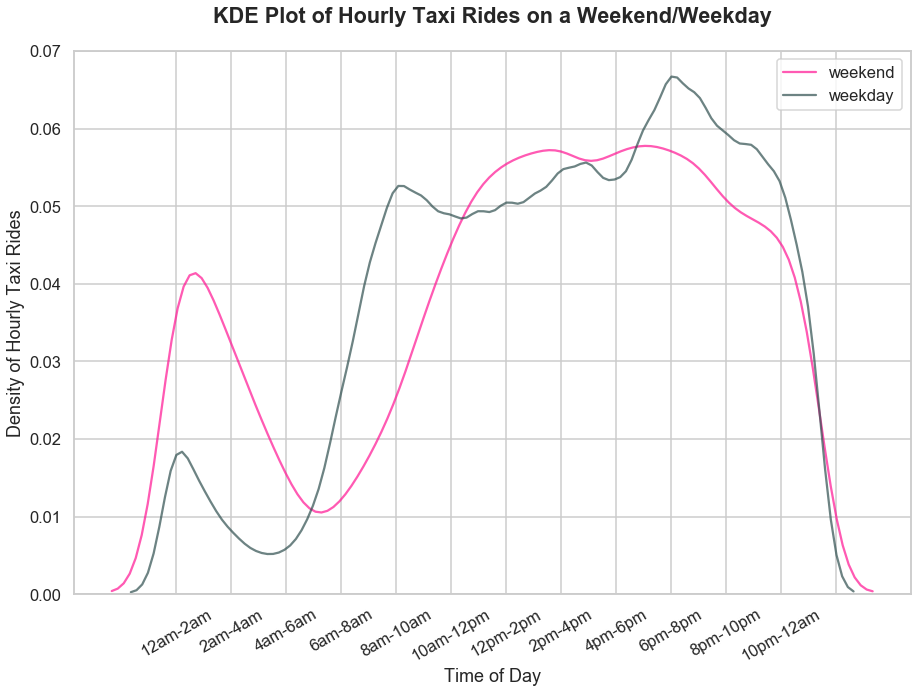

In [9]:
isweekend_df=scaled_daily_df.copy()
isweekend_df["isweekend"]=isweekend_df["pickup_dayofweek"].isin([5,6])
isweekend_df=isweekend_df.astype({'isweekend': 'int32'})

isweekend_y_df=isweekend_df[isweekend_df["isweekend"]==1]
isweekend_n_df=isweekend_df[isweekend_df["isweekend"]==0]

df[df["trip_duration_mins"]==0]["trip_distance"]

# accounting for how weekends occur 2/7 and weekdays occur 5/7 of the time
scaled_isweekend_y_df = pd.concat([isweekend_y_df]*5)
scaled_isweekend_n_df = pd.concat([isweekend_n_df]*2)

# f, axes = plt.subplots(1, 2, figsize=(20, 20), sharex=True)
plt.figure(figsize=(15,10))
sns.distplot(pd.to_datetime(isweekend_y_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend", kde_kws={"color":"deeppink", 'alpha': 0.7})
sns.distplot(pd.to_datetime(isweekend_n_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False,  label="weekday", kde_kws={"color":"darkslategray", 'alpha': 0.7})
plt.xticks(np.arange(0,25,2), labels=["12am-2am","2am-4am","4am-6am","6am-8am","8am-10am","10am-12pm","12pm-2pm","2pm-4pm","4pm-6pm","6pm-8pm","8pm-10pm","10pm-12am"], rotation=30)
plt.xlabel("Time of Day")
plt.ylabel("Density of Hourly Taxi Rides")
plt.legend()
plt.title("KDE Plot of Hourly Taxi Rides on a Weekend/Weekday", fontweight="bold", fontsize="large", y=1.04)
plt.show()

As weekdays segue into weekends, ties are loosened, suits are cast aside and a different rhythm of taxi ridership emerges&mdash;as reflected by the stark shift in the distribution of hourly taxi rides. 

On weekends, a higher density of taxi rides occurs in the late night through early hours of the morning (12-4am), perhaps due to the large crowds staying out late for parties. There is also a sleepier start to the day, as suggested by a much lower&mdash;and less steep an increase in&mdash;the density of taxi rides occurring from 6-10am. On weekday evenings, unsurprisingly, we do not see the same spike in taxi ridership that occurs on from 5-8pm on weekdays as the office crowd knocks off from work and presumably stays in.  

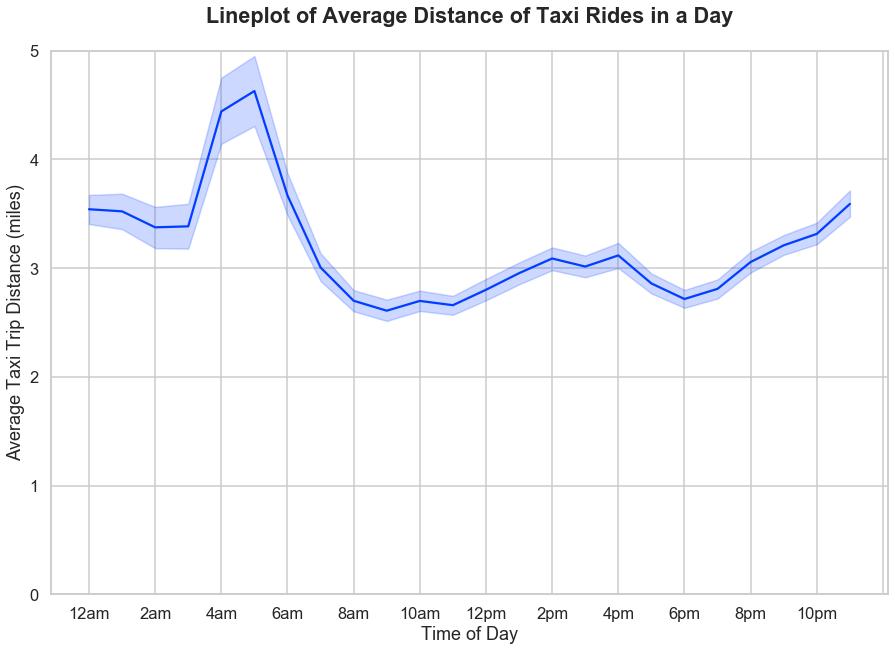

In [10]:
plt.figure(figsize=(15,10))
g=sns.lineplot(pd.to_datetime(df['pickup_datetime']).dt.hour, df["trip_distance"])
plt.xticks(np.arange(0,26, 2), labels=["12am","2am","4am","6am","8am","10am","12pm","2pm","4pm","6pm","8pm","10pm"])
plt.xlabel("Time of Day")
plt.ylim(0,5)
plt.ylabel("Average Taxi Trip Distance (miles)")
plt.title("Lineplot of Average Distance of Taxi Rides in a Day", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Looking at average taxi trip distance throughout a day could hold clues about the roles that taxis play in New Yorkers' daily lives. 

The lineplot above shows that average trip distance peaks at above 3.5 miles between 3 and 6am. Given that the KDE plot previously showed that the fraction of rides at that time is much higher on weekends, it is possible that many taxis hailed at that time are by partygoers who, throughout the night, have found themselves straying further and further from home, and need a safe ride back (no matter how far it is). This spike may also be reflective the NYC subway schedule, as trains operate at reduced frequencies from 3-6am, thus prompting more long-distance rides. 

The lower average trip distances from 8-11am suggest that yellow taxis are more used for shorter-distance commutes to work. For New Yorkers who live outside Manhattan (e.g. Queens, Brooklyn) and work in Manhattan, they would likely take green taxis ("Boro taxis") for the long-distance ride as those are more prevalent in other boroughs. 

Average taxi trip distance stays relatively steady for the remainder of the day, before rising in the late night, perhaps as New Yorkers use hail yellow taxis in Manhattan for outbound travel. 

Having uncovered key trends in NYC taxi ridership, we will address the challenge of predicting daily taxi ridership in NYC.  

# 3. A Daily Perspective: Which Variables are the Best Predictors of Daily Trip Counts?

## 3.1 Laying the Foundations

Now, we will explore the question of which variables are best used to predict daily trip counts. The search for an answer will uncover the hidden factors that drive millions of commuters' decisions to ride in yellow taxis each day. 

For this part, we will create a new dataframe ("trip_counts_df") that aggregates trip counts by dates. 

In our full dataset, there were two kinds of variables&mdash;trip-basis variables (e.g. `fare_amount`,`trip_distance`) and day-basis variables (e.g. `max_temp`,`date`). Here, we omit all trip-basis variables as they are no longer relevant from a daily perspective. 

In [11]:
trip_count_by_date_df = df.groupby("date")["pickup_datetime"].count()
trip_count_by_date_df = trip_count_by_date_df.to_frame(name="trip_count")
trip_count_by_date_df.reset_index(inplace=True)
trip_counts_df = trip_count_by_date_df.merge(df[["date","maxtemp","mintemp","avetemp","hdd","cdd","precipitation","newsnow","snowdepth","pickup_dayofweek"]], how="inner", on="date")

## 3.2 Dealing with Seasonality

We suspect that day-to-day taxi ridership would have a strong seasonal trend. For instance, large numbers of investment bankers may commute to work by taxi every Monday, but spend time at home or play golf (and hence not taking a taxi) every Sunday. We will use a time series plot to understand the seasonal trend&mdash;particularly the length of each season and the magnitude of fluctuation across seasons. 

/Users/josiah/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


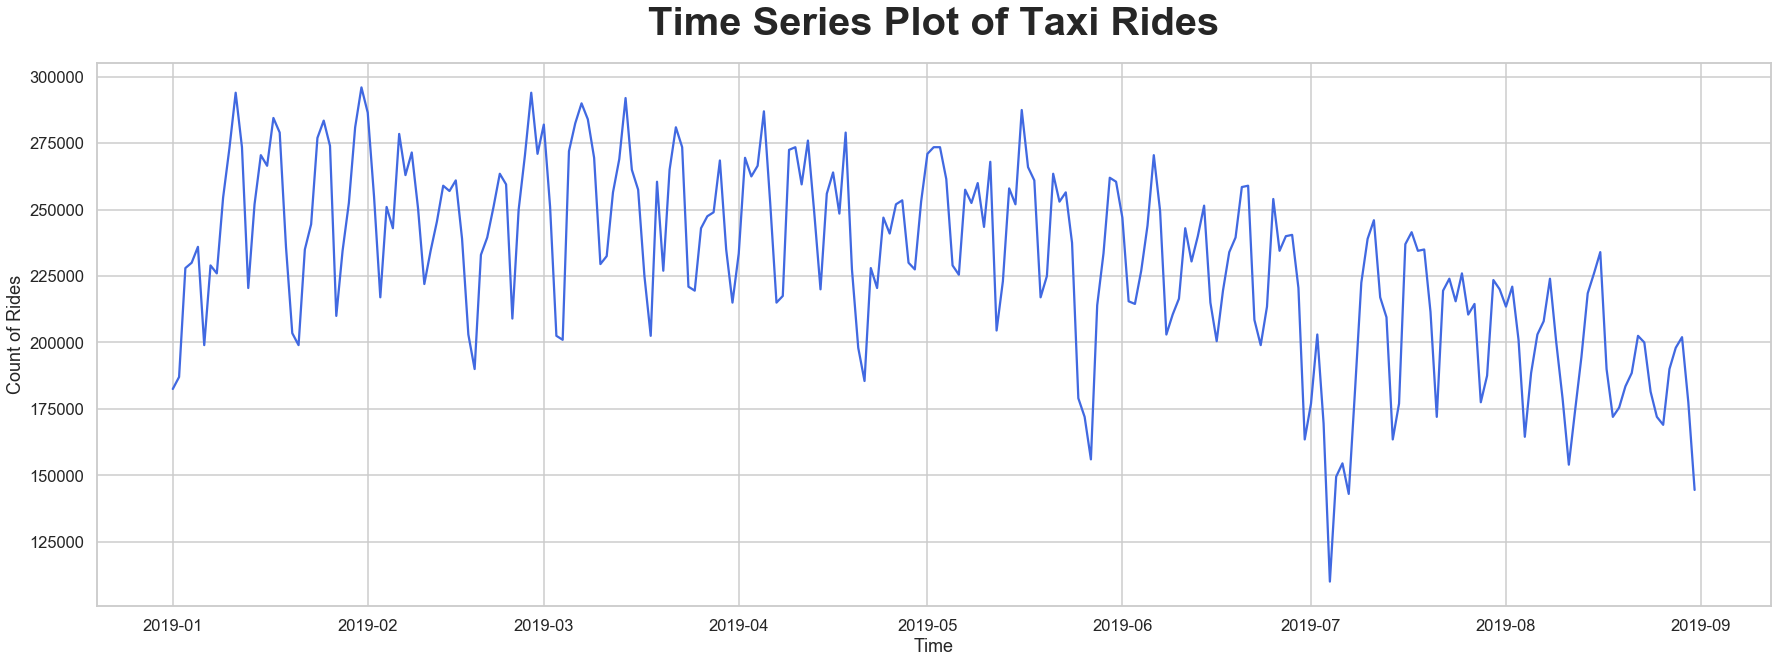

In [12]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(trip_counts_df["date"],trip_counts_df["trip_count"], color="royalblue")
ax.set_title("Time Series Plot of Taxi Rides", fontweight="bold", fontsize="40", y=1.04)
ax.set_xlabel("Time")
ax.set_ylabel("Count of Rides")
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
plt.show()

The time series plot shows approximately four peaks and troughs each month, thus indicating a weekly trend. The magnitude of fluctuation is very large, with a difference of up to 75,000 rides between each peak and trough. 

There is also a monthly trend, with monthly taxi ridership decreasing as the months go by.

To capture this seasonality in our dataset (and subsequent model), we will create the following variables:

- `isweekend`: a binary variable that codes whether the date is a weekend *(1: yes, 0: no)*
- 6 dummy variables for the day of week (`monday`, `tuesday`, `wednesday`, `thursday`,`friday`, `saturday` and `sunday`)
- 8 dummy variables for month of 2019 (`january`, `february`, `march`, `april`, `may`, `june`, `july`, `august`)

In [13]:
trip_counts_df["isweekend"]=np.where(trip_counts_df["pickup_dayofweek"].isin([5,6]),1,0)

# creating 6 dummy variables for day of week
PUdayofweek_dummies=pd.get_dummies(trip_counts_df["pickup_dayofweek"])
PUdayofweek_dummies.rename(columns={0:"monday",1:"tuesday",2:"wednesday",3:"thursday",4:"friday",5:"saturday",6:"sunday"}, inplace=True)
trip_counts_df=trip_counts_df.join(PUdayofweek_dummies)

# creating 8 dummy variables for month of 2019
PUmonth_dummies=pd.get_dummies(trip_counts_df["date"].dt.month_name())
trip_counts_df=trip_counts_df.join(PUmonth_dummies)
trip_counts_df.rename(columns={"January":"january","February":"february","March":"march","April":"april","May":"may","June":"june","July":"july","August":"august"}, inplace=True)

#reordering columns
trip_counts_df=trip_counts_df[['date', 'trip_count', 'maxtemp', 'mintemp', 'avetemp', 'hdd', 'cdd',
       'precipitation', 'newsnow', 'snowdepth', 'pickup_dayofweek',
       'isweekend', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
       'saturday', 'sunday', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august']]

In [14]:
trip_counts_df["pickup_month"]=trip_counts_df["date"].dt.month_name()

## 3.3 Examining Correlations with `trip_count` through Visualizations

First, we will use a correlation heatmap to identify explanatory variables with noticeable correlations with our response variable (`trip_count`). We are looking out for squares in the heatmap with a reddish or bluish hue (absolute correlations of more than 0.1.

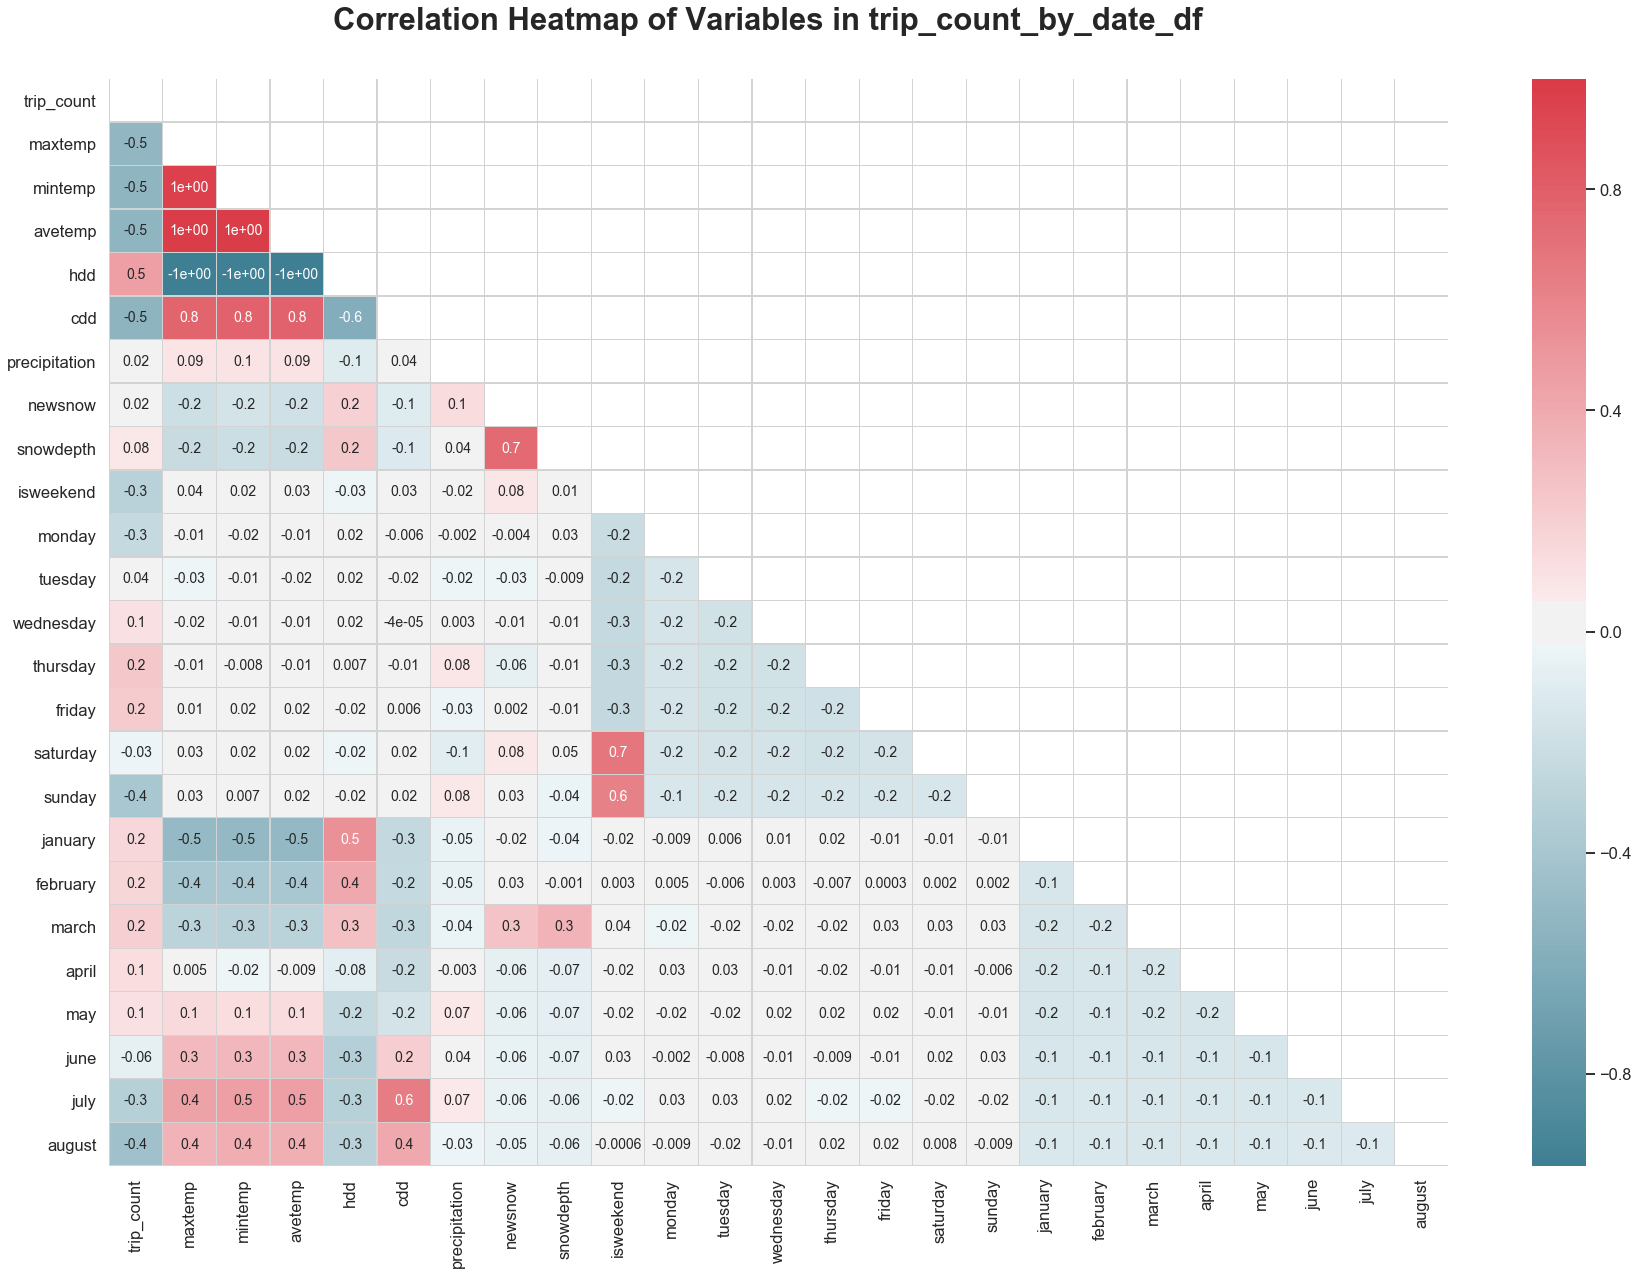

In [15]:
corr=trip_counts_df.drop(columns=["pickup_dayofweek", "pickup_month"]).corr()
plt.figure(figsize=(30, 20))
mask = np.tril(trip_counts_df.corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,annot_kws={"fontsize":14},fmt = '.1',  cmap=sns.diverging_palette(220, 10, as_cmap=True),  mask = mask, linewidths=0.2, linecolor='lightgray')

#fix for seaborn bug where top and bottom boxes are cut off (adapted from https://github.com/mwaskom/seaborn/issues/1773)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.suptitle("Correlation Heatmap of Variables in trip_count_by_date_df", fontweight="bold", fontsize="xx-large", x=0.43, y=0.93)
plt.show()

Looking on this heatmap, the explanatory variables that are noticeably correlated with `trip_count` are:
- Weather variables (`maxtemp`, `mintemp`, `avetemp`, `hdd` and `cdd`)


- Date-related variables, including `isweekend`, day of week dummies (`monday` to `sunday`) and month of 2019 dummies (`january` to `august`)

Contrary to our initial beliefs that rainy or snowy weather would increase taxi ridership, precipitation and snowfall are have only negligible correlations with `trip_count`. 

We will proceed with some visualizations to better understand the strength and direction of the relationship between these explanatory variables and daily taxi ridership. 

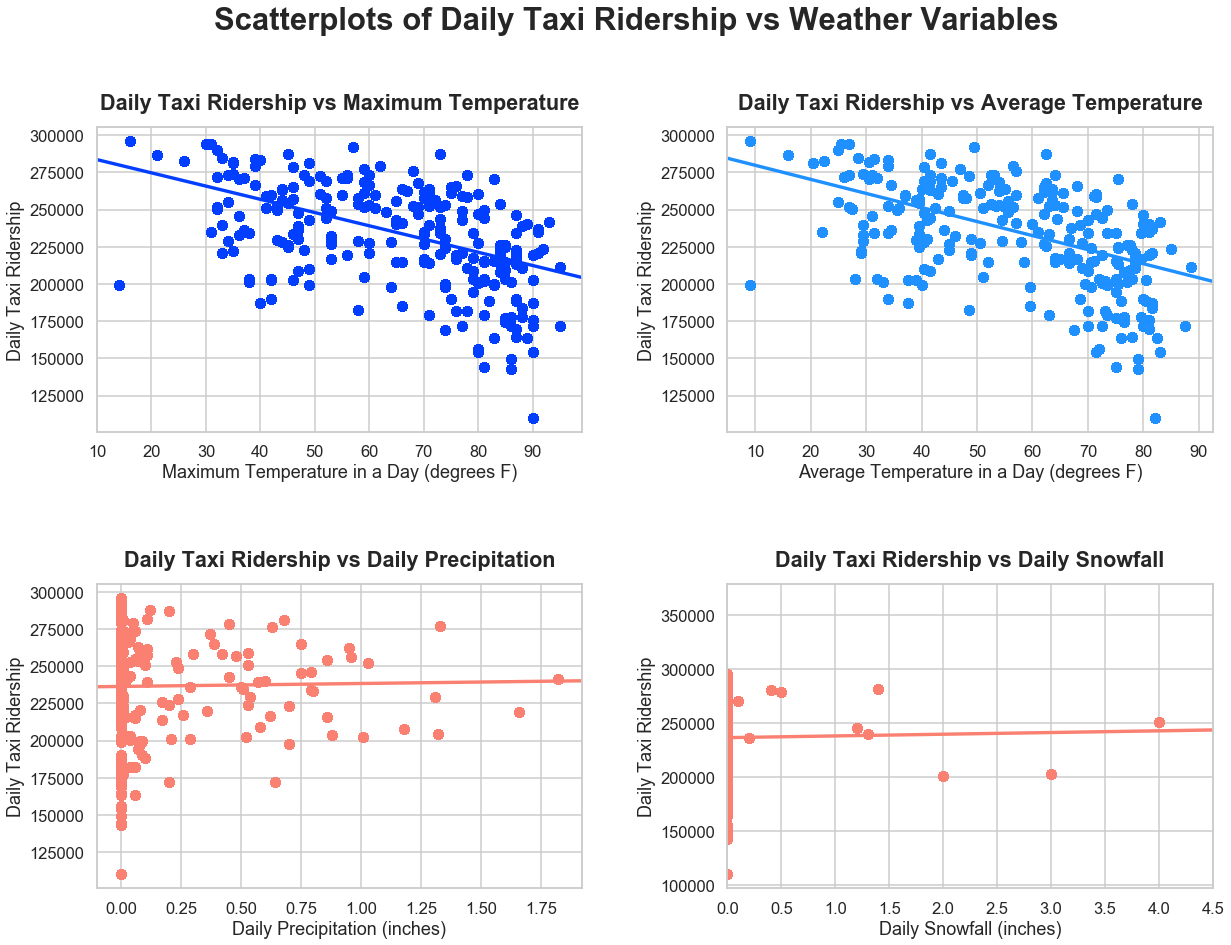

In [17]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

sns.regplot(trip_counts_df["maxtemp"],trip_counts_df["trip_count"], ax=axes[0,0]).set(ylabel='Daily Taxi Ridership', xlabel="Maximum Temperature in a Day (degrees F)")
axes[0,0].set_yticklabels((axes[0,0].get_yticks() * 1/0.002).astype(int))
axes[0,0].set_title("Daily Taxi Ridership vs Maximum Temperature", fontweight="bold", fontsize="large", y=1.04)

sns.regplot(trip_counts_df["avetemp"],trip_counts_df["trip_count"], ax=axes[0,1], color="dodgerblue").set(ylabel='Daily Taxi Ridership', xlabel="Average Temperature in a Day (degrees F)")
axes[0,1].set_yticklabels((axes[0,1].get_yticks() * 1/0.002).astype(int))
axes[0,1].set_title("Daily Taxi Ridership vs Average Temperature", fontweight="bold", fontsize="large", y=1.04)

sns.regplot(trip_counts_df["precipitation"],trip_counts_df["trip_count"], ax=axes[1,0], color="salmon").set(ylabel='Daily Taxi Ridership', xlabel="Daily Precipitation (inches)")
axes[1,0].set_yticklabels((axes[1,0].get_yticks() * 1/0.002).astype(int))
axes[1,0].set_title("Daily Taxi Ridership vs Daily Precipitation", fontweight="bold", fontsize="large", y=1.04)

sns.regplot(trip_counts_df["newsnow"],trip_counts_df["trip_count"], ax=axes[1,1], color="salmon").set(ylabel='Daily Taxi Ridership', xlabel="Daily Snowfall (inches)")
axes[1,1].set_xlim(0,max(trip_counts_df["newsnow"])+0.5)
axes[1,1].set_yticklabels((axes[1,1].get_yticks() * 1/0.002).astype(int))
axes[1,1].set_title("Daily Taxi Ridership vs Daily Snowfall", fontweight="bold", fontsize="large", y=1.04)

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.suptitle("Scatterplots of Daily Taxi Ridership vs Weather Variables", fontweight="bold", fontsize="xx-large", y=1)

plt.show()



The top two scatterplots show that both maximum temperature (a proxy of daytime temperature) and average temperature are negatively correlated to daily taxi ridership. With an increase in maximum temperature, especially above the 60-degree mark, New Yorkers rely less on taxis. Perhaps, they turn to other forms of transportation such as the walking or Citi Bikes that are much more pleasurable without the bitter cold. 

Though `precipitation` appeared uncorrelated in the correlation heatmap, the bottom left scatterplot shows that precipitation is still related to taxi ridership. Low precipitation levels do not guarantee low daily taxi ridership (as evidenced by the high trip counts occurring on 0-precipitation days), but high precipitation levels are always accompanied by at least a moderate level of taxi ridership. 

Likewise, for daily snowfall, high snowfall days always have at least an moderate level of taxi ridership, but low- and no-snowfall days have trip counts spanning the spectrum of low to high. Perhaps, the weak and ambiguous relationship between `newsnow` and `trip_counts` is due to the very few data points for snowy days (10 out of 243 days). 

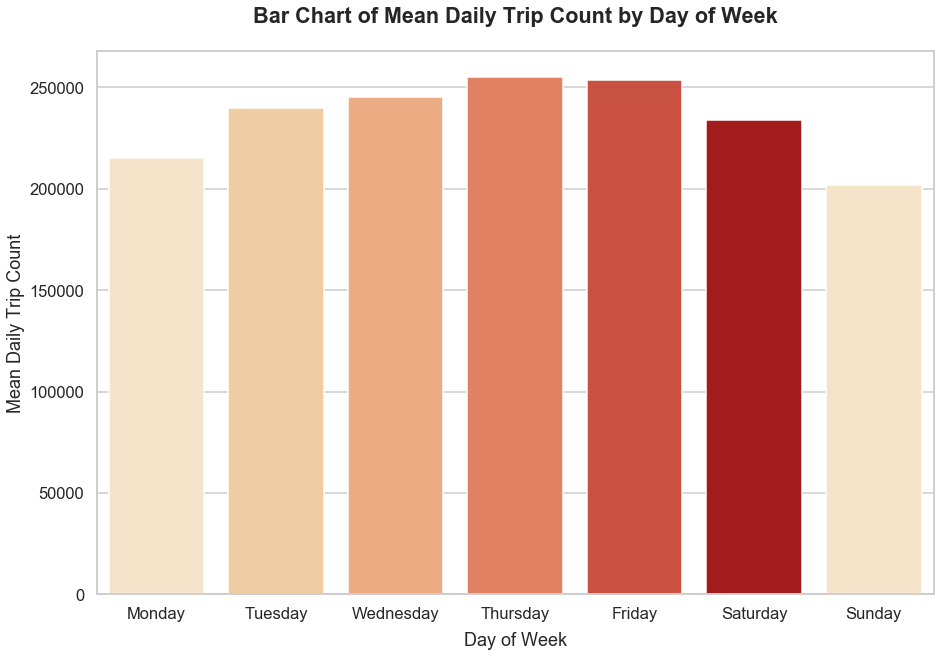

In [18]:
plt.figure(figsize=(15,10))
ax=sns.barplot(trip_counts_df["pickup_dayofweek"], trip_counts_df["trip_count"], ci=None, palette=sns.color_palette("OrRd"))
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
ax.set_ylabel('Mean Daily Trip Count')
ax.set_xlabel('Day of Week', labelpad=10)
plt.title("Bar Chart of Mean Daily Trip Count by Day of Week", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Having deduced weekly seasonality from the time series previously, we would now like to analyze how taxi ridership actually rises and falls within a week. 

Across the days of a week, the mean daily trip count is lowest on Sunday, which is sensible as taxi commutes to work do not occur on a rest day. Certain populations may also be refraining from travelling on Sunday due to religious reasons. Saturday has a higher mean trip count that Sunday, as it is only a partial rest day for some employees and many Friday night party-goers would ride taxis home on early Saturday morning. 

After Sunday, taxi ridership climbs day-by-day to reach its peak on Thursday, before falling as the weekend arrives. 

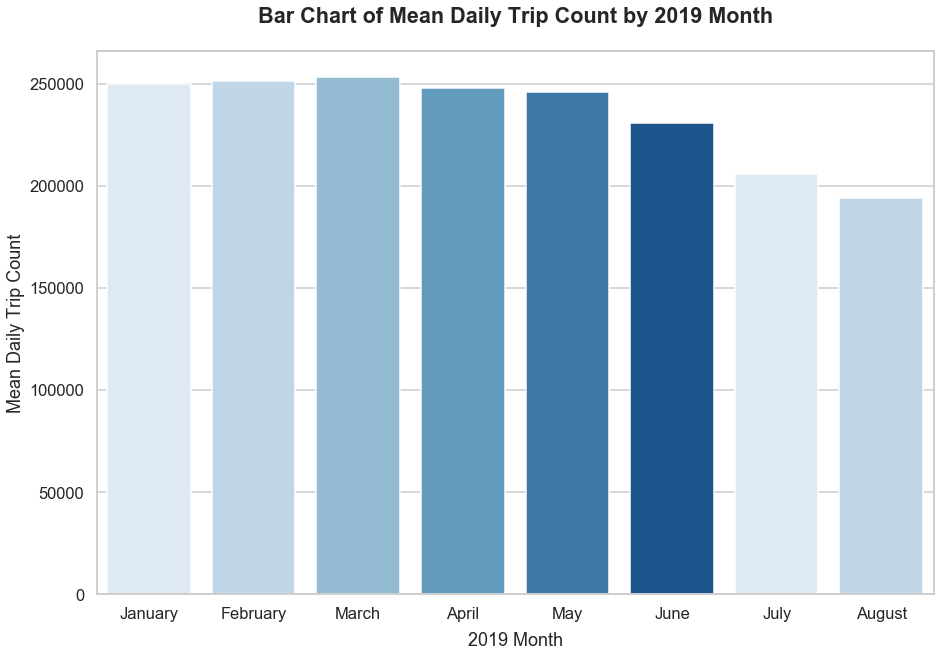

In [19]:
plt.figure(figsize=(15,10))
ax=sns.barplot(trip_counts_df["pickup_month"], trip_counts_df["trip_count"], ci=None, palette=sns.color_palette("Blues"))
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
ax.set_ylabel('Mean Daily Trip Count')
ax.set_xlabel('2019 Month', labelpad=10)
plt.title("Bar Chart of Mean Daily Trip Count by 2019 Month", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Echoing the trend of monthly decrease in the time series plot, the mean daily trip count over the 2019 months seems to have fell at an exponential rate before tapering off at a low in August. 

This also agrees with what we see in the earlier correlation heatmap&mdash; that January 2019 had a 0.2 positive correlation with `trip_counts`, and this correlation fell exponentially over the months to reach -0.4 in August 2019. 

## 3.4 Linear Regression

### 3.4.1 Building of Model

We will use the Akaike’s Information Criterion (AIC) to select a linear regression model with the best relative quality—the best balance between goodness of fit and complexity. 

In [20]:
def minAIC_OLS(X,y):
    variables = X.columns
    model = sm.OLS(y,X[variables]).fit()
    while True:
        print(f'old model aic: {model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        newmodel = sm.OLS(y,X[newvariables]).fit()
        print(f'new model aic: {newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model,variables
linear_model_cols=["maxtemp","avetemp", "precipitation","hdd","cdd","newsnow","snowdepth","tuesday","wednesday","thursday","friday","saturday","sunday","february","march","april","may","june","july","august"]
X=trip_counts_df[linear_model_cols]
X = sm.add_constant(X)
print(f"Initial Variables are {np.array(X.columns)}\n")
y=trip_counts_df["trip_count"]
new_linear_model , linear_variables = minAIC_OLS(X,y)
new_linear_model = sm.OLS(y,X[linear_variables]).fit()
print(f"After Optimization, New model AIC is {new_linear_model.aic}\n")
print(f"After Optimization, New Variables are {np.array(new_linear_model.params.index)}")

/Users/josiah/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Initial Variables are ['const' 'maxtemp' 'avetemp' 'precipitation' 'hdd' 'cdd' 'newsnow'
 'snowdepth' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday'
 'february' 'march' 'april' 'may' 'june' 'july' 'august']

old model aic: 1120596.0431770398
new model aic: 1120595.473186707
old model aic: 1120595.473186707
new model aic: 1120762.5764242536
After Optimization, New model AIC is 1120595.473186707

After Optimization, New Variables are ['const' 'maxtemp' 'avetemp' 'precipitation' 'hdd' 'cdd' 'newsnow'
 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday' 'february'
 'march' 'april' 'may' 'june' 'july' 'august']


Unsurprisingly, `snowdepth`, a explanatory variable with negligible correlation, has fallen out of the optimized model. Note that we omitted the `monday` and `january` dummy variables to avoid overparameterizing our model. 

In [21]:
results = new_linear_model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             trip_count   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                 1.496e+04
Date:                Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                        00:15:09   Log-Likelihood:            -5.6028e+05
No. Observations:              112477   AIC:                         1.121e+06
Df Residuals:                  112457   BIC:                         1.121e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1542.9228     28.063     54.981      0.000    1487.920    1597.926
maxtemp           1.0670      0.046     23.389      0.000       0.978       1.156
avetemp         -19.0296      0.440    -43.274      0.000     -19.892     -18.168
precipitation    18.2569      0.348     52.473      0.000      17.575      18.939
hdd             -15.9550      0.433    -36.848      0.000     -16.804     -15.106
cdd              17.2771      0.432     39.959      0.000      16.430      18.125
newsnow         -14.1556      0.304    -46.621      0.000     -14.751     -13.560
tuesday          50.4503      0.402    125.358      0.000      49.661      51.239
wednesday        59.3109      0.403    147.323      0.000      58.522      60.100
thursday         79.6366      0.399    199.514      0.000      78.854      80.419
friday           79.3958      0.400    198.298      0.000      78.611      80.181
saturday         42.1870      0.409    103.030      0.000      41.384      42.990
sunday          -26.8614      0.425    -63.185      0.000     -27.695     -26.028
february         14.1588      0.420     33.703      0.000      13.335      14.982
march            32.6054      0.444     73.398      0.000      31.735      33.476
april            42.5916      0.557     76.400      0.000      41.499      43.684
may              45.7127      0.632     72.349      0.000      44.474      46.951
june             33.7102      0.745     45.219      0.000      32.249      35.171
july            -11.8874      0.914    -13.008      0.000     -13.679     -10.096
august          -40.8576      0.826    -49.453      0.000     -42.477     -39.238
==============================================================================
Omnibus:                    32255.664   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           116255.940
Skew:                          -1.419   Prob(JB):                         0.00
Kurtosis:                       7.093   Cond. No.                     2.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Performing the joint F-test at the 5% significance level, we see that the F statistic's p-value is 0. Hence, we reject the null hypothesis that none of the explanatory variables are related to `trip_counts`. In other words, our model fits the data better than an intercept-only model. 

An R-squared value of 0.717 means that 71.7% of the variation in `trip_counts` about its mean can be explained by our current fitted model. Seasonality plays an large role in our model's fit&mdash;if we include only day of week dummies, our R-squared is lower at 0.621; if we exclude both day of week and month dummies, our R-squared falls to 0.341. 

Using a two-tailed t-test at a 5% significant level, we reject the null hypothesis that a variable's coefficient is 0 if its upper-tail p-value is below 0.025. All the explanatory variables have p-values of 0 (<0.025) and are thus significant.  

To draw meaningful interpretations from the results, we must multiply each coefficient by 1/0.002, as we sampled only 0.002 of all taxi rides in the raw dataset. 

In [22]:
scaled_value_coefs=pd.DataFrame(new_linear_model.params*1/0.002)
scaled_value_coefs.rename(columns={0: "Scaled Values"}, inplace=True)
scaled_value_coefs

,Scaled Values
const,771461.404497
maxtemp,533.517421
avetemp,-9514.814892
precipitation,9128.453156
hdd,-7977.486483
cdd,8638.570782
newsnow,-7077.805924
tuesday,25225.141881
wednesday,29655.431387
thursday,39818.317232


Some key findings from the linear regression model include:

- Echoing the negative correlations between temperatures and `trip_count` we saw earlier, a 1-degree F increase in `avetemp` (average daily temperature) is linked to a drop in daily taxi ridership by 9,515 rides, when covariates are held constant. An increase in `maxtemp` is linked to a surprising increase in daily trip counts, suggesting that the negative correlations we observed earlier for `maxtemp` could be due to its interaction with `avetemp`. 


- A 1-inch increase in precipitation is linked to a 9,128 increase in daily trip counts, holding covariates constant, suggesting that more rain indeed spurs taxi commutes. There is a unanticipated relationship observed in snowfall. A 1-inch increase in `newsnow` (new daily snowfall) is associated with 7078 fewer daily rides, when covariates are held constant. It is possible that new snowfall affects the safety of roads and clogs up traffic, thus deterring people from commuting via taxi. 


- Day of week has an important effect on `trip_count`. A Sunday is linked to a decrease in daily trip counts by 13,431 rides, relative to a Monday. Thursday and Friday are linked to the largest increases in taxi ridership as compared to Monday, which matches the intuition we got in the bar chart earlier. Overall, we can see an day-by-day increase in taxi ridership from Monday till Friday, before a sharp drop in taxi ridership on Saturday and a sharper drop on Sunday. 


- Month has an outsize relationship with daily taxi ridership. When covariates are held constant, February has 7,079 more daily rides than January, and daily taxi ridership continues to increase (in comparison to January) to reach a peak of 22,856 rides higher than January in May. It then falls drastically in the next 3 months such that August has 20,429 fewer daily rides than January. Interestingly, the exponential month-on-month decrease in daily rides that we gleaned from the bar chart and correlation matrix earlier no longer exists when we hold covariates constant. 

### 3.4.2 Evaluation of Model 

For us to be able to draw valid inferences, the linear regression model has to satisfy four assumptions: 

1. Model is linear in the predictors
2. Residuals have a constant variance (are homoskedastic)
3. Residuals are mutually independent
4. Residuals are normally distributed

We will test each of the assumptions above. 

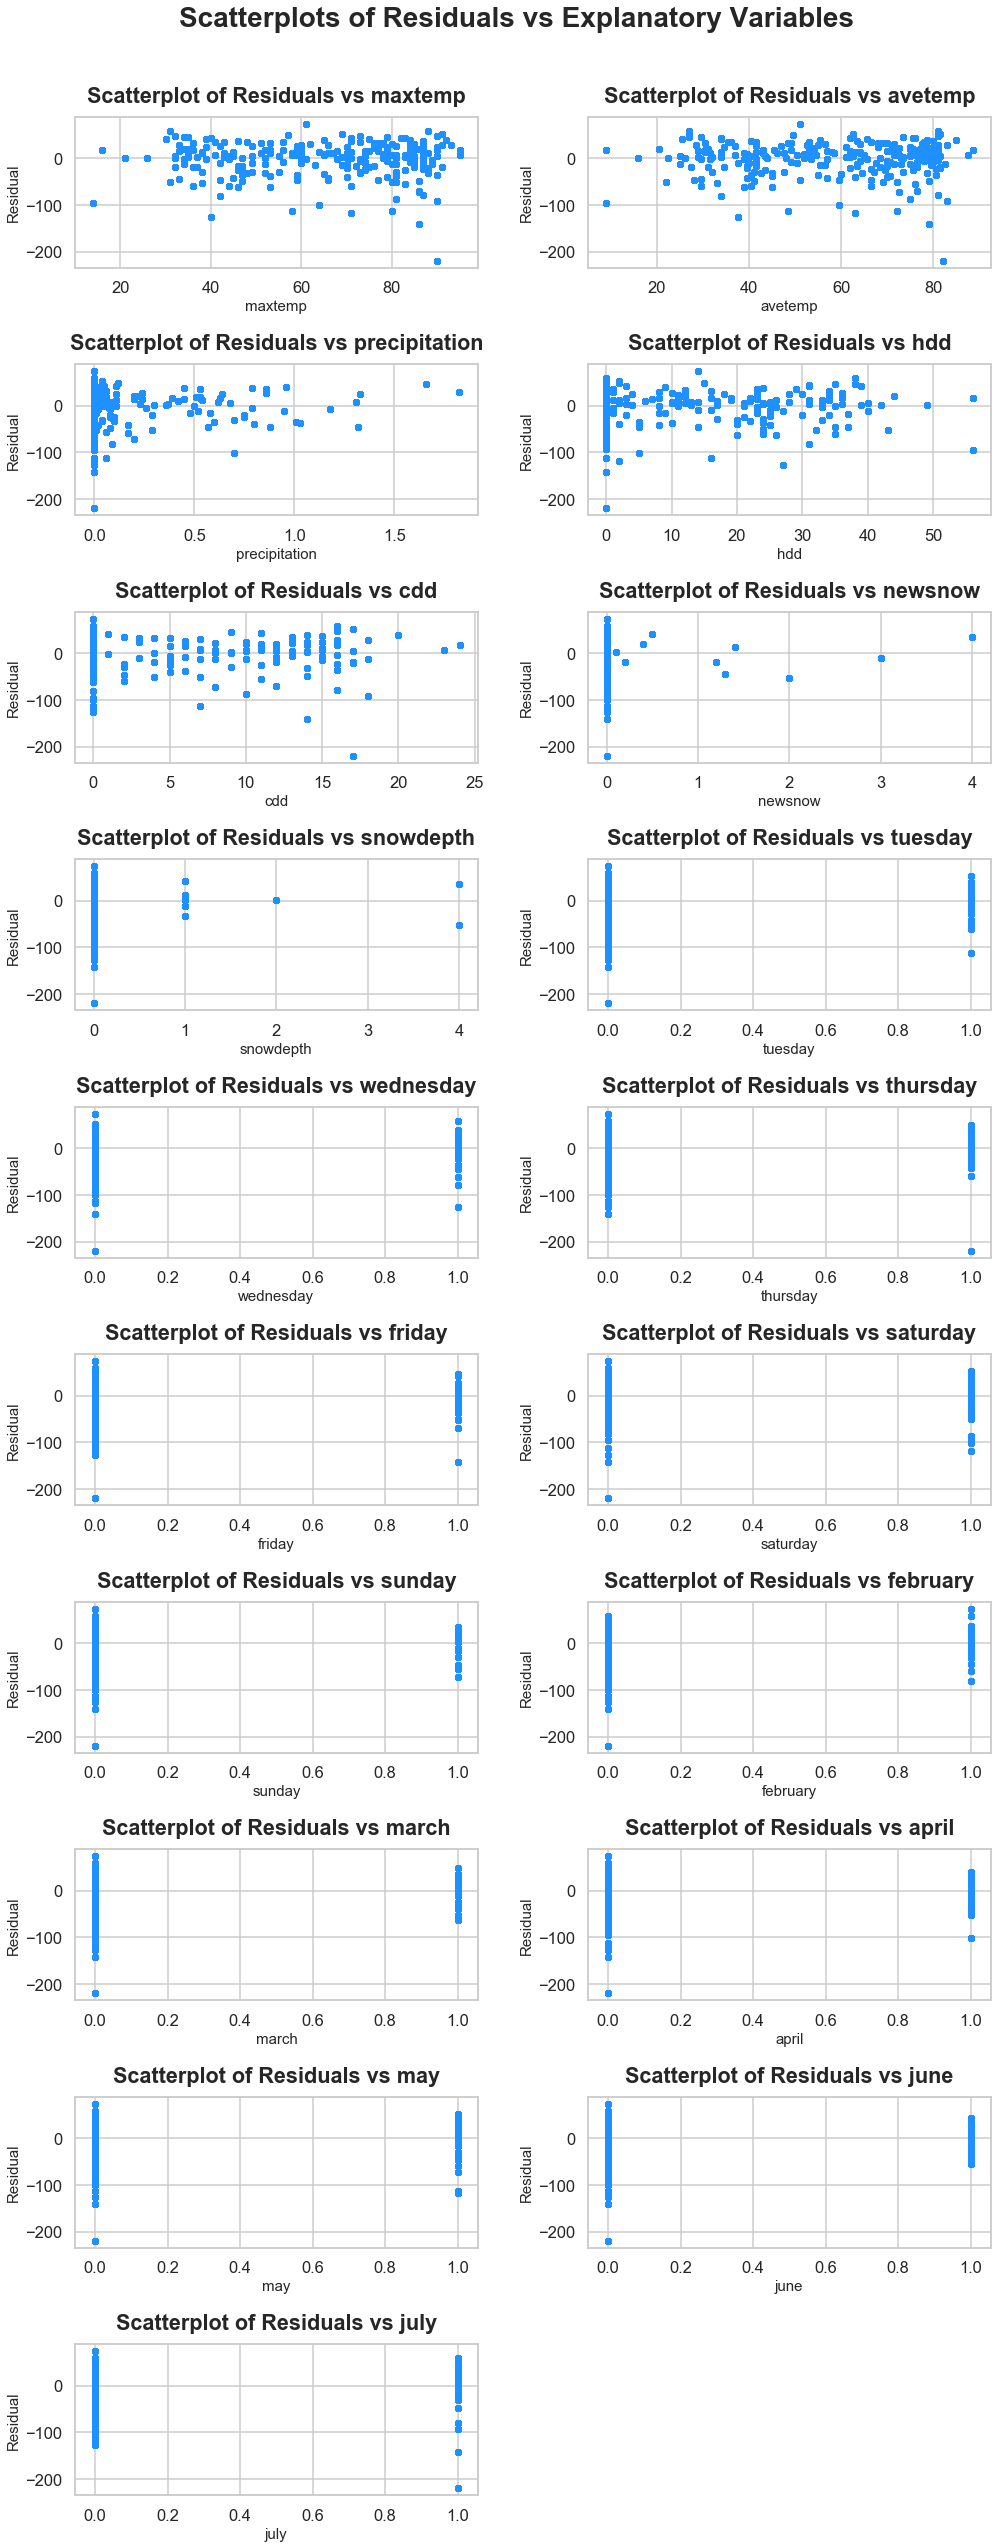

In [23]:
res=new_linear_model.resid
f, ax = plt.subplots(nrows=10, ncols=2, figsize=(15,35))
f.delaxes(ax[9,1])
f.tight_layout(pad=3, h_pad=3.5)

for c, colname in enumerate(linear_model_cols):
    rowindex = c//2
    colindex = 0 if c%2==0 else 1
    ax[rowindex][colindex].scatter(trip_counts_df[f"{colname}"],res, color="dodgerblue", marker=".")
    ax[rowindex][colindex].set_title(f"Scatterplot of Residuals vs {colname}", fontweight="bold", fontsize="large", pad=15)
    ax[rowindex][colindex].set_ylabel("Residual", fontsize=15)
    ax[rowindex][colindex].set_xlabel(f"{colname}", fontsize=15)
    f.suptitle('Scatterplots of Residuals vs Explanatory Variables', fontsize="28", fontweight="bold", y=1.02)
plt.show()

1st Assumption Satisfied: Since the average values of the residuals do not depend on the values of each explanatory variable, our model is indeed linear in its predictors. 

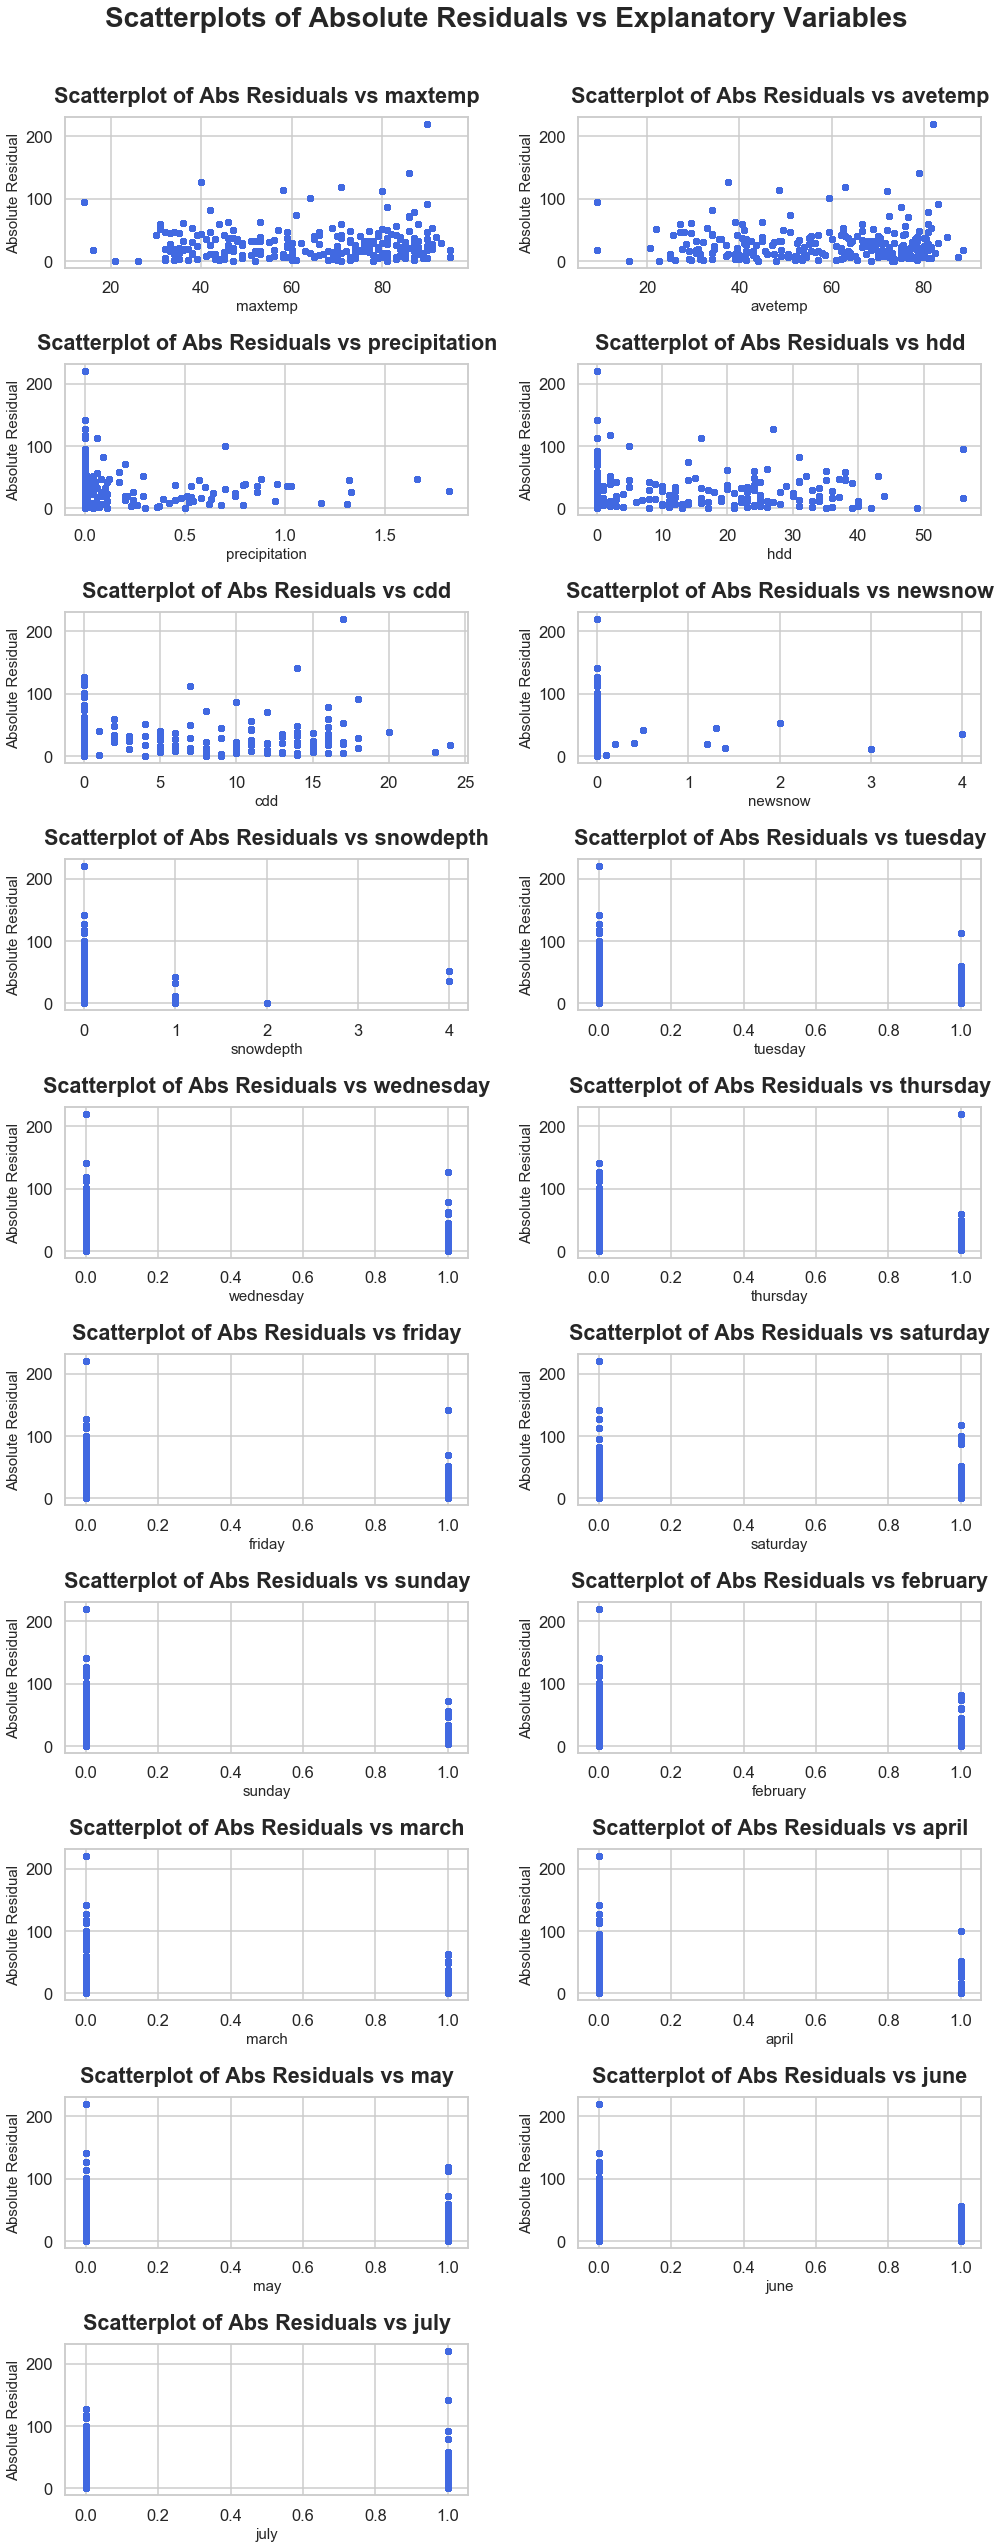

In [24]:
abs_res=np.abs(np.array(res))
f, ax = plt.subplots(nrows=10, ncols=2, figsize=(15,35))
f.delaxes(ax[9,1])
f.tight_layout(pad=3, h_pad=3.5)

for c, colname in enumerate(linear_model_cols):
    rowindex = c//2
    colindex = 0 if c%2==0 else 1
    ax[rowindex][colindex].scatter(trip_counts_df[f"{colname}"],abs_res, color="royalblue", marker=".")
    ax[rowindex][colindex].set_title(f"Scatterplot of Abs Residuals vs {colname}", fontweight="bold", fontsize="large", pad=15)
    ax[rowindex][colindex].set_ylabel("Absolute Residual", fontsize=15)
    ax[rowindex][colindex].set_xlabel(f"{colname}", fontsize=15)
    f.suptitle('Scatterplots of Absolute Residuals vs Explanatory Variables', fontsize="28", fontweight="bold", y=1.02)
plt.show()

2nd Assumption Satisfied: Since the distribution of absolute residuals does not depend on value of each explanatory variable, the variance of the residuals is constant. 

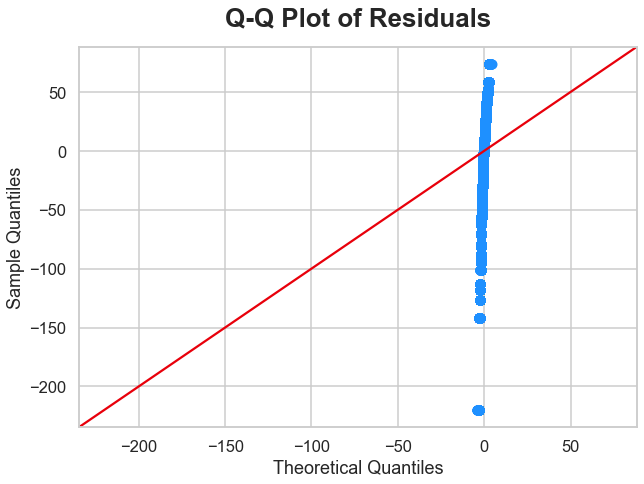

In [25]:
f, ax = plt.subplots(figsize=(10,7))
fig = sm.qqplot(res, line="45",ax=ax, color="dodgerblue")
ax.set_title("Q-Q Plot of Residuals", fontweight="bold", fontsize="x-large", y=1.04)
plt.show()

3rd Assumption Not Satisfied: Since the Q-Q plot of the residuals does not yield a straight 45-degree line, the residuals are not normally distributed.

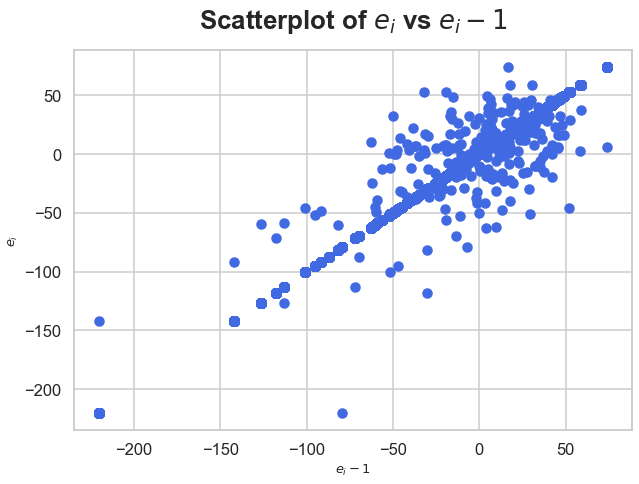

In [26]:
res=new_linear_model.resid
plt.figure(figsize=(10,7))
plt.scatter(res[:-1], res[1:], color="royalblue")
plt.title("Scatterplot of $e_i$ vs $e_i-1$", fontweight="bold", fontsize="x-large", y=1.04)
plt.ylabel("$e_i$", fontsize=13)
plt.xlabel("$e_i-1$", fontsize=13)
plt.show()

4th Assumption Not Satisfied: Since there is a clear relationship between consecutive residuals, residuals are not mutually independent. This is most likely due to the vulnerability of time series regression models to serial correlation (read more at http://people.duke.edu/~rnau/testing.htm). 

Overall, given that our linear model violates the assumptions of normal and mutually independent residuals, we would not proceed to predict `trip_counts` using it. The predictions that it generates could potentially be biased or misleading. 

# 4. Zooming into Manhattan: What Variables are Useful to Predict the Odds of a Downtown/Non-Downtown Ride?

## 4.1 Laying the Foundations

Now, we will dive into the question of which variables can help us predict the odds of a Manhattan taxi ride having a downtown pickup/dropoff location. For this part, we will create several new variables:
- `is_downtown`: a binary variable that codes whether a ride has a downtown pickup/dropoff location *(1: yes, 0: no)*


- `PUtime_of_day`: a variable that describes the time of day of a ride pickup *(early morning: 3am-7am, morning rush hour: 7am-11am, lunchtime: 11am-3pm, evening rush hour: 3pm-7pm, late evening: 7pm-11pm, late night: 11pm-3am)*


- `DOtime_of_day`: a variable that describes the time of day of a ride dropoff *(early morning: 3am-7am, morning rush hour: 7am-11am, lunchtime: 11am-3pm, evening rush hour: 3pm-7pm, late evening: 7pm-11pm, late night: 11pm-3am)*


- 6 dummy variables for pickup time of day (`pickup_early_morning`, `pickup_morning_rush_hour`, `pickup_lunchtime`, `pickup_evening_rush_hour`,`pickup_late_evening` and `pickup_late_night`)


- 6 dummy variables for pickup time of day (`dropoff_early_morning`, `dropoff_morning_rush_hour`, `dropoff_lunchtime`, `dropoff_evening_rush_hour`,`dropoff_late_evening` and `dropoff_late_night`)

Before we start, we will import the taxi zone lookup table (adapted from https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv). This table maps pickup/dropoff location IDs to named locations in Manhattan, which we classified into 4 zones:

- Uptown: above 59th Street


- Midtown: 34th-59th Street


- Lower-Midtown: 14th-33rd Street


- Downtown: below 14th Street


We will also create a new dataframe with Manhattan-only rides and perform some data manipulation to ready it for logistic regression. 

In [27]:
#importing taxi zone lookup dataset that has been preprocessed and tagged with Manhattan zones (Uptown, Midtown, Lower-Midtown, Downtown)
taxi_zone_lookup_df = pd.read_csv("taxi_zone_lookup.csv")

#merging is_weekend_df with taxi_zone_lookup_df
lagg_df=isweekend_df.merge(taxi_zone_lookup_df,how="left",left_on=isweekend_df["PULocationID"], right_on=taxi_zone_lookup_df["LocationID"])
lagg_df.rename(columns={"Borough":"PUborough","Zone":"PUzone","service_zone":"PUservice_zone","manhattan_zone":"PUmanhattan_zone"},inplace=True)
lagg_df.drop(columns=["key_0","LocationID"],inplace=True)
lagg_df=lagg_df.merge(taxi_zone_lookup_df,how="left",left_on=lagg_df["DOLocationID"], right_on=taxi_zone_lookup_df["LocationID"])
lagg_df.rename(columns={"Borough":"DOborough","Zone":"DOzone","service_zone":"DOservice_zone","manhattan_zone":"DOmanhattan_zone"},inplace=True)
lagg_df.drop(columns=["key_0","LocationID"],inplace=True)


#categorizing time of day into 6 names (early morning, morning rush hour, lunchtime, evening rush hour, late evening, late night)
lagg_df["PUtime_of_day"]=pd.to_datetime(lagg_df['pickup_datetime']).dt.hour
lagg_df.replace({"PUtime_of_day": {3:"early morning",4:"early morning",5:"early morning",6:"early morning",7:"morning rush hour",8:"morning rush hour",9:"morning rush hour",10:"morning rush hour",11:"lunchtime",12:"lunchtime",13:"lunchtime",14:"lunchtime",15:"evening rush hour",16:"evening rush hour",17:"evening rush hour",18:"evening rush hour",19:"late evening",20:"late evening",21:"late evening",22:"late evening", 23:"late night",0:"late night",1:"late night",2:"late night"}}, inplace=True)
lagg_df["DOtime_of_day"]=pd.to_datetime(lagg_df['dropoff_datetime']).dt.hour
lagg_df.replace({"DOtime_of_day": {3:"early morning",4:"early morning",5:"early morning",6:"early morning",7:"morning rush hour",8:"morning rush hour",9:"morning rush hour",10:"morning rush hour",11:"lunchtime",12:"lunchtime",13:"lunchtime",14:"lunchtime",15:"evening rush hour",16:"evening rush hour",17:"evening rush hour",18:"evening rush hour",19:"late evening",20:"late evening",21:"late evening",22:"late evening", 23:"late night",0:"late night",1:"late night",2:"late night"}}, inplace=True)

#removing taxi rides with no charge or disputed taxi fares
lagg_df = lagg_df.query("(payment_type!=3.0) & (payment_type!=4.0)")
lagg_df = lagg_df.astype({"payment_type":"int32"})

#creating two datasets: one for taxi rides with Manhattan pickups and the other for taxi rides with Manhattan dropoffs
pu_manhattan_df=lagg_df[~pd.isnull(lagg_df["PUmanhattan_zone"])]
do_manhattan_df=lagg_df[~pd.isnull(lagg_df["DOmanhattan_zone"])]

#creating a larger dataset for taxi rides with Manhattan pickups or dropoffs
manhattan_df=lagg_df[~pd.isnull(lagg_df["PUmanhattan_zone"])|~pd.isnull(lagg_df["DOmanhattan_zone"])]

#splitting manhattan_df into two datasets based on whether a ride had downtown pickups/dropoffs
PUDO_downtown_y_df=manhattan_df[(manhattan_df["PUmanhattan_zone"]=="Downtown") | (manhattan_df["DOmanhattan_zone"]=="Downtown")]
PUDO_downtown_n_df=manhattan_df[(manhattan_df["PUmanhattan_zone"]!="Downtown") & (manhattan_df["DOmanhattan_zone"]!="Downtown")]

#creating an is_downtown column to code downtown/non-downtown rides
manhattan_df["is_downtown"]=np.where((manhattan_df["PUmanhattan_zone"]=="Downtown") | (manhattan_df["DOmanhattan_zone"]=="Downtown"),1,0)

#replacing PUtime_of_day with 6 columns of dummy variables
PUtimeofday_dummies=pd.get_dummies(manhattan_df["PUtime_of_day"])
manhattan_df=manhattan_df.join(PUtimeofday_dummies)
manhattan_df.rename(columns={"early morning":"pickup_early_morning", "morning rush hour":"pickup_morning_rush_hour", "lunchtime":"pickup_lunchtime", "evening rush hour":"pickup_evening_rush_hour", "late evening":"pickup_late_evening", "late night":"pickup_late_night"}, inplace=True)

#replacing DOtime_of_day with 6 columns of dummy variables
DOtimeofday_dummies=pd.get_dummies(manhattan_df["DOtime_of_day"])
manhattan_df=manhattan_df.join(DOtimeofday_dummies)
manhattan_df.rename(columns={"early morning":"dropoff_early_morning", "morning rush hour":"dropoff_morning_rush_hour", "lunchtime":"dropoff_lunchtime", "evening rush hour":"dropoff_evening_rush_hour", "late evening":"dropoff_late_evening", "late night":"dropoff_late_night"}, inplace=True)
manhattan_df.drop(columns=["PUtime_of_day","DOtime_of_day"], inplace=True)

/Users/josiah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
manhattan_df["pickup_dropoff_early_morning"]=np.where((manhattan_df["pickup_early_morning"]==1) | (manhattan_df["dropoff_early_morning"]==1),1,0)
manhattan_df["pickup_dropoff_morning_rush_hour"]=np.where((manhattan_df["pickup_morning_rush_hour"]==1) | (manhattan_df["dropoff_morning_rush_hour"]==1),1,0)
manhattan_df["pickup_dropoff_lunchtime"]=np.where((manhattan_df["pickup_lunchtime"]==1) | (manhattan_df["dropoff_lunchtime"]==1),1,0)
manhattan_df["pickup_dropoff_evening_rush_hour"]=np.where((manhattan_df["pickup_evening_rush_hour"]==1) | (manhattan_df["dropoff_evening_rush_hour"]==1),1,0)
manhattan_df["pickup_dropoff_late_evening"]=np.where((manhattan_df["pickup_late_evening"]==1) | (manhattan_df["dropoff_late_evening"]==1),1,0)
manhattan_df["pickup_dropoff_late_night"]=np.where((manhattan_df["pickup_late_night"]==1) | (manhattan_df["dropoff_late_night"]==1),1,0)

## 4.2 Examining Correlations with `is_downtown` through Visualizations

As a first step, we will run a correlation heatmap to identify the explanatory variables with noticeable correlations with our response variable (`is_downtown`). 

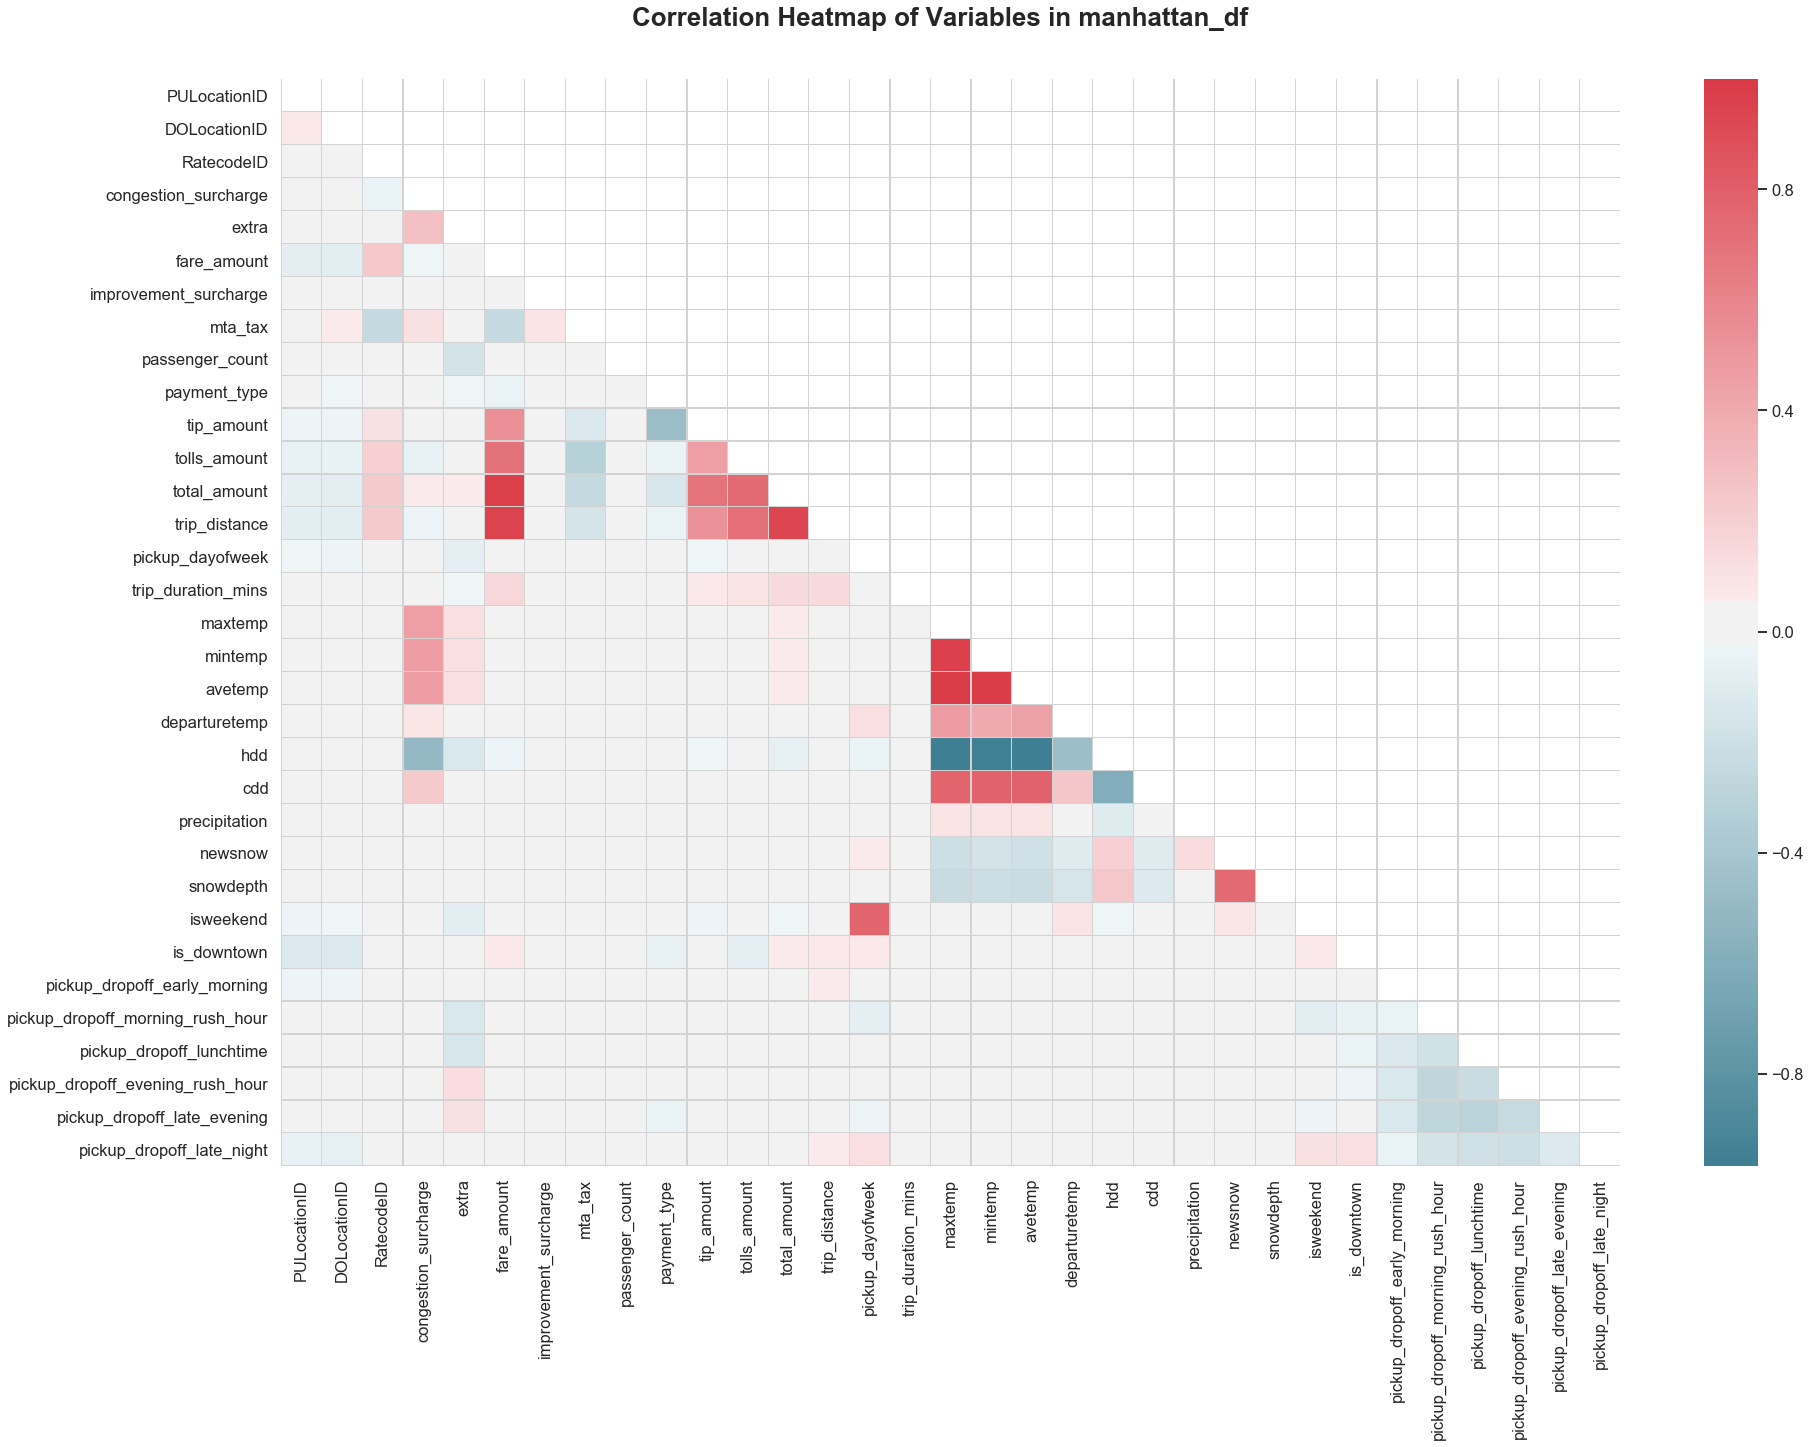

In [29]:
corr=manhattan_df.drop(columns=["pickup_early_morning","pickup_morning_rush_hour","pickup_lunchtime","pickup_evening_rush_hour","pickup_late_evening","pickup_late_night","dropoff_early_morning","dropoff_morning_rush_hour","dropoff_lunchtime","dropoff_evening_rush_hour","dropoff_late_evening","dropoff_late_night"]).corr()
plt.figure(figsize=(30,20))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax=sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True),  mask = mask, linewidths=0.2, linecolor='lightgray')

#fix for seaborn bug where top and bottom boxes are cut off (adapted from https://github.com/mwaskom/seaborn/issues/1773)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.suptitle("Correlation Heatmap of Variables in manhattan_df", fontweight="bold", fontsize="x-large", x=0.43, y=0.93)
plt.show()

Looking on this heatmap, explanatory variables correlated with `is_downtown` include:
- Whether the taxi ride occurred on a weekend (`isweekend`) 
- Time of day (especially `pickup_dropoff_morning_rush_hour`, `pickup_dropoff_lunchtime`, `pickup_dropoff_evening_rush_hour` and `pickup_dropoff_late_night`)
- Amount of payment (`fare_amount`,`tip_amount` and `total_amount`)
- Distance logged in a taxi ride (`trip_distance`)
- Payment type (`payment_type`)

We will proceed with some visualizations to better understand the strength and direction of the relationship between these explanatory variables and `is_downtown`. 

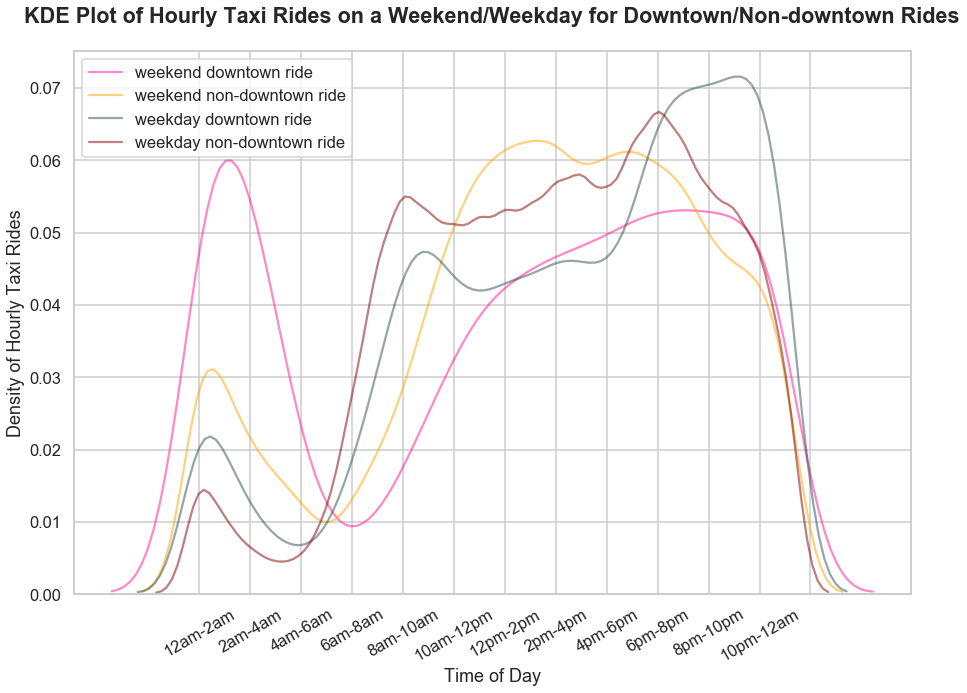

In [30]:
plt.figure(figsize=(15,10))
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==1) & (manhattan_df["is_downtown"]==1)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend downtown ride", kde_kws={"color":"deeppink", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==1) & (manhattan_df["is_downtown"]==0)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend non-downtown ride", kde_kws={"color":"orange", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==0) & (manhattan_df["is_downtown"]==1)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekday downtown ride", kde_kws={"color":"darkslategray", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==0) & (manhattan_df["is_downtown"]==0)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekday non-downtown ride", kde_kws={"color":"maroon", 'alpha': 0.5})
plt.xticks(np.arange(0,25,2), labels=["12am-2am","2am-4am","4am-6am","6am-8am","8am-10am","10am-12pm","12pm-2pm","2pm-4pm","4pm-6pm","6pm-8pm","8pm-10pm","10pm-12am"], rotation=30)
plt.xlabel("Time of Day")
plt.ylabel("Density of Hourly Taxi Rides")
plt.title("KDE Plot of Hourly Taxi Rides on a Weekend/Weekday for Downtown/Non-downtown Rides", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Using a KDE plot, we discover the following: 
- On late nights (11pm-3am), the density of weekend downtown rides is much higher than that of weekday downtown rides, thus conforming with the correlation heatmap's results. It also makes sense as many late-night parties occur in the downtown area on weekends, drawing more taxi rides to and from downtown on weekends.


- On early mornings (3am-7am), the density of weekend downtown rides is higher than that of weekday downtown rides from 3-5am but dips below the gray line from 5-7am. the "canceling out" of opposite effects may explain why the correlation betwen early mornings and `is_downtown` is negligible. 


- On late evenings (7pm-11pm), the density of downtown rides (gray and pink lines) is generally higher than that of non-downtown rides (represented by brown and yellow lines). This suggests that the late evening time window might be a good variable to use to predict `is_downtown` odds. 

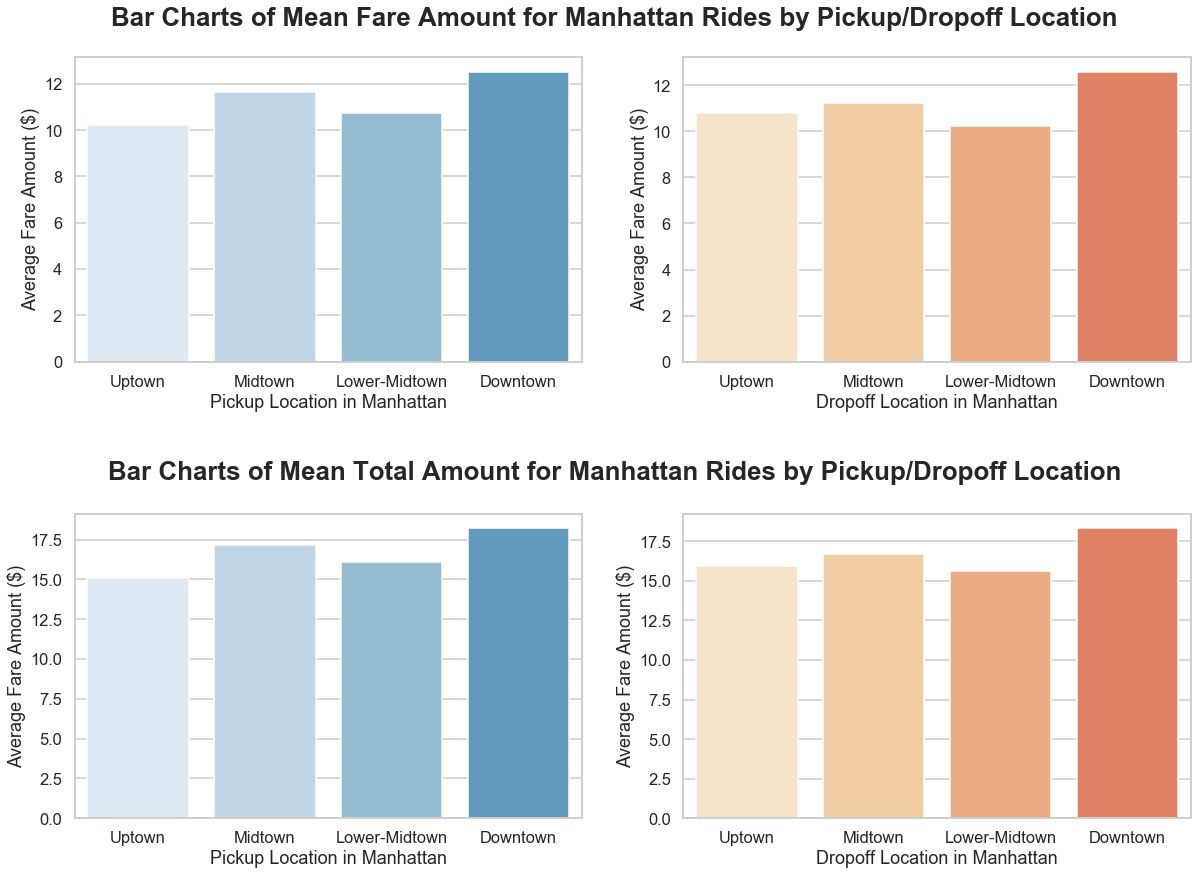

In [31]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["fare_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,0], palette=sns.color_palette("Blues")).set(ylabel='Average Fare Amount ($)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["fare_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,1],  palette=sns.color_palette("OrRd")).set(ylabel='Average Fare Amount ($)', xlabel="Dropoff Location in Manhattan")

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["total_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,0], palette=sns.color_palette("Blues")).set(ylabel='Average Fare Amount ($)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["total_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,1],  palette=sns.color_palette("OrRd")).set(ylabel='Average Fare Amount ($)', xlabel="Dropoff Location in Manhattan")

plt.figtext(0.5,0.93, "Bar Charts of Mean Fare Amount for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.figtext(0.5,0.48, "Bar Charts of Mean Total Amount for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.subplots_adjust(hspace = 0.5 )

plt.show()

The bar charts above show that for both taxi pickups and dropoffs, the mean fare amount is significantly higher for the downtown area than the non-downtown area, thus echoing the positive correlation between `is_downtown` and `fare_amount`. The mean total amount (which includes fare amount, tip amount and tolls) is similarly higher for downtown rides than non-downtown rides. 

What is the intuition behind this? Fare amount is a influenced by both trip distance (\\$0.50 per 1/5 mile above 12mph) and trip duration (\\$0.50 per 60 seconds in slow traffic). Do downtown trips tend to clock a longer distance, or do they simply take a longer time traversing the same distance (have a lower speed)?

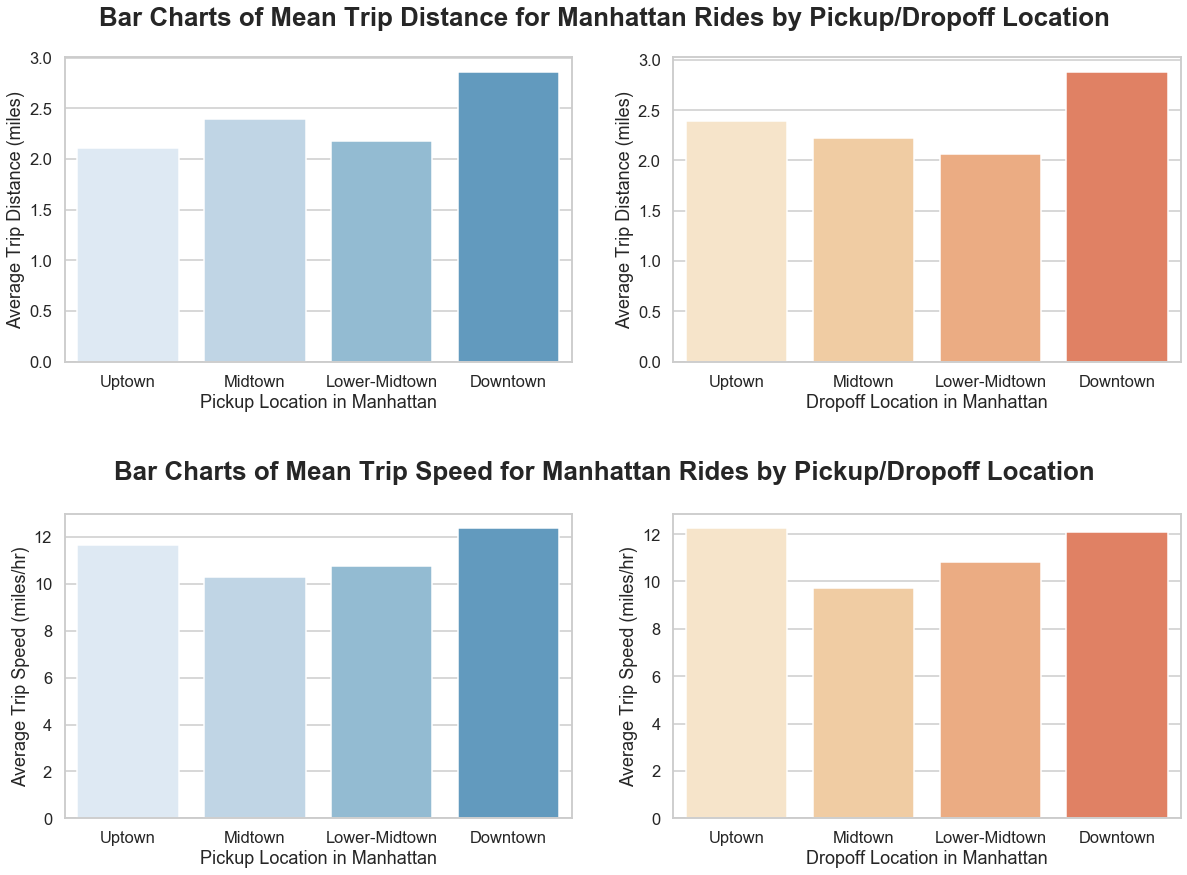

In [32]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["trip_distance"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,0], palette=sns.color_palette("Blues")).set(ylabel='Average Trip Distance (miles)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["trip_distance"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,1],  palette=sns.color_palette("OrRd")).set(ylabel='Average Trip Distance (miles)', xlabel="Dropoff Location in Manhattan")

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["trip_distance"]/pu_manhattan_df["trip_duration_mins"]*60, order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,0], palette=sns.color_palette("Blues")).set(ylabel='Average Trip Speed (miles/hr)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["trip_distance"]/do_manhattan_df["trip_duration_mins"]*60, order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,1],  palette=sns.color_palette("OrRd")).set(ylabel='Average Trip Speed (miles/hr)', xlabel="Dropoff Location in Manhattan")

plt.figtext(0.5,0.93, "Bar Charts of Mean Trip Distance for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.figtext(0.5,0.48, "Bar Charts of Mean Trip Speed for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.subplots_adjust(hspace = 0.5 )

plt.show()

It turns out that trip distance is the main factor at play for the difference in fare amounts between downtown and non-downtown trips. For downtown rides, the mean trip distance is more than half a mile longer than the mean trips distances of uptown, midtown and lower-midtown rides. This could be due to the heavy reliance of taxis among employees in the downtown financial services industry to commute to and from home (in other Manhattan zones or NYC boroughs). 

The mean speed for downtown rides is actually greater than or equal to the mean speed of non-downtown rides, suggesting that "duration in slow traffic" component in taxi fares is in fact lower for downtown rides. 

## 4.3 Logistic Regression

### 4.3.1 Building of model

Like what we did for the linear regression model in Section 3.4, we will use the Akaike’s Information Criterion (AIC) to select a logistic regression model with the best relative quality&mdash;the best balance between goodness of fit and complexity. If our interpretations were accurate in Section 4.2, the mix of variables that yield the lowest AIC should largely be the same as those we identified. 

In [33]:
Xcols=["fare_amount", "total_amount", "tip_amount", "tolls_amount","payment_type", "trip_duration_mins", "trip_distance", "passenger_count", "isweekend", "precipitation", "pickup_dropoff_early_morning", "pickup_dropoff_morning_rush_hour", "pickup_dropoff_evening_rush_hour", "pickup_dropoff_late_evening", "pickup_dropoff_late_night"]

def minAIC(X,y):
    variables = X.columns
    model = sm.Logit(y,X[variables]).fit()
    while True:
        print(f'Old model AIC: {model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        newmodel = sm.Logit(y,X[newvariables]).fit()
        print(f'New model AIC: {newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model,variables

X=manhattan_df[Xcols]
X = sm.add_constant(X)
print(f"Initial Variables are {np.array(X.columns)}\n")
y=manhattan_df["is_downtown"]
new_model, logit_variables = minAIC(X, y)
new_model = sm.Logit(y, X[logit_variables]).fit()
print(f"After Optimization, New model AIC is {new_model.aic}\n")
print(f"After Optimization, New Variables are {np.array(new_model.params.index)}")

Initial Variables are ['const' 'fare_amount' 'total_amount' 'tip_amount' 'tolls_amount'
 'payment_type' 'trip_duration_mins' 'trip_distance' 'passenger_count'
 'isweekend' 'precipitation' 'pickup_dropoff_early_morning'
 'pickup_dropoff_morning_rush_hour' 'pickup_dropoff_evening_rush_hour'
 'pickup_dropoff_late_evening' 'pickup_dropoff_late_night']

Optimization terminated successfully.
         Current function value: 0.531611
         Iterations 6
Old model AIC: 226149.620931423
Optimization terminated successfully.
         Current function value: 0.531616
         Iterations 6
New model AIC: 226149.52527102103
Old model AIC: 226149.52527102103
Optimization terminated successfully.
         Current function value: 0.531629
         Iterations 6
New model AIC: 226153.2541973502
Optimization terminated successfully.
         Current function value: 0.531616
         Iterations 6
After Optimization, New model AIC is 226149.52527102103

After Optimization, New Variables are ['const' 'far

As expected, the variables with negligible correlation, namely `passenger_count`, `avetemp`, `maxtemp` and `trip_duration_mins`, fall out of the optimized model. 

However, there are some unexpected explanatory variables (with little correlation to `is_downtown` previously) added to the optimized model. These are `precipitation`, `tip_amount` and `trip_duration_mins`. 

The explanatory variables with a noticeable correlation to `is_downtown` previously have all been included in the optimized model. These factors are `fare_amount`, `total_amount`, `tip_amount`, `tolls_amount`, `payment_type`, `trip_distance`, `isweekend` and the time of day variables (`pickup_dropoff_early_morning`, `pickup_dropoff_morning_rush_hour`, `pickup_dropoff_evening_rush_hour`,`pickup_dropoff_late_evening` and `pickup_dropoff_late_night`). Notice that we excluded `pickup_dropoff_lunchtime` to avoid over-parameterizing the model. 

Next, we will proceed to interpret the coefficients of the logistic regression. 

In [34]:
results = new_model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_downtown   No. Observations:               212672
Model:                          Logit   Df Residuals:                   212657
Method:                           MLE   Df Model:                           14
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.05051
Time:                        00:19:53   Log-Likelihood:            -1.1306e+05
converged:                       True   LL-Null:                   -1.1907e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -1.7031      0.029    -58.576      0.000      -1.760      -1.646
fare_amount                         -0.0719      0.006    -12.870      0.000      -0.083      -0.061
total_amount                         0.0944      0.005     17.816      0.000       0.084       0.105
tip_amount                          -0.0854      0.006    -13.812      0.000      -0.097      -0.073
tolls_amount                        -0.5275      0.009    -61.214      0.000      -0.544      -0.511
payment_type                        -0.2749      0.014    -19.058      0.000      -0.303      -0.247
trip_duration_mins                   0.0002   7.04e-05      2.427      0.015    3.29e-05       0.000
trip_distance                        0.0822      0.005     15.275      0.000       0.072       0.093
isweekend                            0.3353      0.012     28.823      0.000       0.312       0.358
precipitation                       -0.0697      0.017     -4.179      0.000      -0.102      -0.037
pickup_dropoff_early_morning         0.1200      0.025      4.721      0.000       0.070       0.170
pickup_dropoff_morning_rush_hour    -0.0824      0.017     -4.845      0.000      -0.116      -0.049
pickup_dropoff_evening_rush_hour    -0.0421      0.015     -2.754      0.006      -0.072      -0.012
pickup_dropoff_late_evening          0.2606      0.015     17.902      0.000       0.232       0.289
pickup_dropoff_late_night            0.6248      0.017     36.097      0.000       0.591       0.659
====================================================================================================
"""

In [35]:
np.exp(new_model.params)

const                               0.182117
fare_amount                         0.930659
total_amount                        1.099015
tip_amount                          0.918165
tolls_amount                        0.590079
payment_type                        0.759625
trip_duration_mins                  1.000171
trip_distance                       1.085716
isweekend                           1.398356
precipitation                       0.932668
pickup_dropoff_early_morning        1.127473
pickup_dropoff_morning_rush_hour    0.920862
pickup_dropoff_evening_rush_hour    0.958817
pickup_dropoff_late_evening         1.297664
pickup_dropoff_late_night           1.867875
dtype: float64

Using a two-tailed z-test at a 5% significant level, we reject the null hypothesis that a variable's coefficient is 0 if its upper-tail p-value is below 0.025. `trip_duration_mins` and `pickup_dropoff_evening_rush_hour` are statistically insignificant as their p-values are 0.086 and 0.052 respectively (both above 0.025). 

Some noteworthy findings from the logistic regression model include:

- A late-night time (as indicated by `pickup_dropoff_late_night`) increases the odds of a ride originating/ending in downtown by 86.8%, while a late-evening time (as indicated by `pickup_dropoff_late_evening`) boosts those odds by 29.8%. Echoing earlier visualizations, a weekend pickup or dropoff (as indicated by `is_weekend`) increases those odds by 39.8%. 


- A 1-mile increase in `trip_distance` boosts the odds of a downtown ride by 8.6%. 


- Echoing a trend of greater preference for (and ability to afford) credit cards among downtown employees, the use of credit cards instead of cash, as indicated by a `payment_type` of 0 instead of 1, increases the odds of a downtown ride by 24%.


- Despite the positive correlation between `fare_amount` and the `is_downtown` in the correlation matrix, a \\$1 increase in fare amount leads to a 8.2\% decrease in the odds of a Manhattan ride having a downtown origin/destination. That being said, a \\$1 increase in `total_amount` is linked to a 9.9% increase in the odds of a downtown ride.



### 4.3.2 Evaluation of Model

We then train the logistic regression model on a training set and use it to predict `is_downtown` odds on a test set, with the goal of evaluating the model's classification ability.

In [36]:
logit_variables=list(logit_variables)
logit_variables.remove("const")
y=manhattan_df["is_downtown"]
X=manhattan_df[logit_variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
lgtmodel = LogisticRegression(solver = 'newton-cg').fit(X_train,y_train)

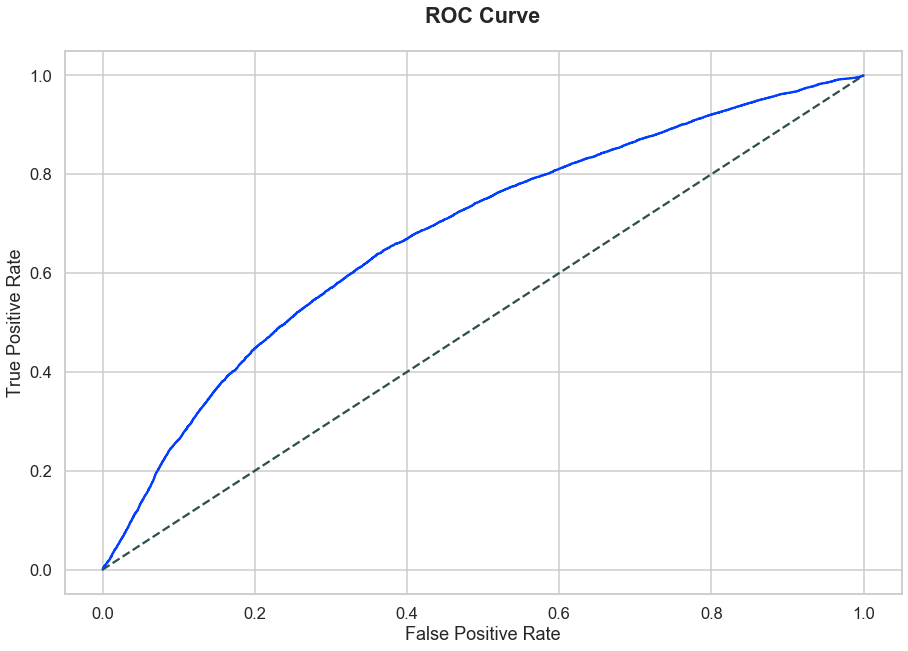

In [37]:
y_pred_probs = lgtmodel.predict_proba(X_test[logit_variables])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.figure(figsize=(15,10))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],color="darkslategray", linestyle="dashed")

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve", fontweight="bold", fontsize="large", y=1.04)
plt.show()

The ROC curve above illustrates the diagnostic ability of our model at different discrimination thresholds. With the goal of maximizing the true positive rate while minimizing the false positive rate, we select a threshold that matches a false positive rate of 0.38 for our model. 

In [38]:
y_pred = lgtmodel.predict_proba(X_test)[:,1]>0.24
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(confusion_matrix(y_test, y_pred))

[[30298 17629]
 [ 5656 10219]]


Based on the confusion matrix above, our model has 5004 true positives, 8822 false positives, 15164 true negatives and 2911 false negatives. This yields a true positive rate of 63.2% and a false positive rate of 36.8%. In other words, our model predicts that `is_downtown` is true when it is actually true 63.2% of the time , and it mistakenly predicts that `is_downtown` is true when it is actually false 36.8% of the time. 

In [39]:
lgtscore=lgtmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Logistic Regression is {lgtscore}")

Mean Accuracy Score of Logistic Regression is 0.7486128961474562


Our logistic regression model yields a mean accuracy score of 0.749, meaning that it classifies `is_downtown` values correctly 74.9% of the time. Can we make better predictions with other binary classifiers?

## 4.4 Other Binary Classifiers

The other binary classifiers we experiment with are K Nearest Neighbors, random forests, adaptive boosting (AdaBoost) and decision trees. 

In [40]:
knmodel = KNeighborsClassifier(60)
knmodel.fit(X_train,y_train)
knscore=knmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of K Nearest Neighbors Classifier is {knscore}")

Mean Accuracy Score of K Nearest Neighbors Classifier is 0.7633616501050123


In [41]:
rfmodel = RandomForestClassifier(max_depth=5, n_estimators=5)
rfmodel.fit(X_train,y_train)
rfscore=rfmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Random Forest Classifier is {rfscore}")

Mean Accuracy Score of Random Forest Classifier is 0.7511363280147958


In [42]:
adbmodel = AdaBoostClassifier()
adbmodel.fit(X_train,y_train)
adbscore=adbmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Adaptive Boosting Classifier is {adbscore}")

Mean Accuracy Score of Adaptive Boosting Classifier is 0.7522177988150842


In [43]:
dtmodel = DecisionTreeClassifier(max_depth=10)
dtmodel.fit(X_train,y_train)
dtscore=dtmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Decision Trees Classifier is {dtscore}")

Mean Accuracy Score of Decision Trees Classifier is 0.7671076141813736


Among the four binary classifiers above, all of them have outperformed our logistic regression model slightly in terms of mean accuracy score. The model with the highest prediction accuracy is the decision trees classifier. 

# 5. Conclusion

Without a doubt, the taxi system is an integral part of New York City, so much so that many people may have trouble imagining the city without its distinctive yellow cabs. All day, everyday, taxis travel throughout the crowded streets, keeping the city running smoothly and delivering people from one place to the next. As a part of a greater whole, however, the taxi system is also subject to many external factors that can influence when and where, how far and for how long they travel.  

In this report, we discovered several trends in taxi ridership, both expected and unexpected. We observed that taxi ridership is strongly correlated to weather. However it is less correlated with snowfall, rain and precipitation than we had anticipated, and more correlated to temperature, with a clear downward trend in the number of rides in the summer months. We were initially surprised by the negative correlation between taxi ridership and temperature, because we had previously hypothesized that taxi ridership would be highest on the days that were extremely hot, as people would be less willing to walk or bike. However, our analysis suggests that, on these days, people may be staying inside and avoiding travelling altogether. 

Our research into the characteristics of the average taxi ride discovered that most rides are for short distances and durations only. This is consistent with the high density of living, working, and recreational spaces in the city, as well as with the presence of other options for long distance travel, such as the subway or green taxi system. Furthermore, on average, riders pay almost $15 to travel not more than 2 miles. At this rate, frequent trips of a longer duration or distance may simply be financially unfeasible for many riders. At the very least, the existence of cheaper alternatives such as Uber may discourage riders from taking taxis for a longer trip.

Regarding hourly taxi distribution, we found peak hours of density to be from 6pm-8pm, consistently throughout the week, but most sharply on the weekends. We can imagine that this trend may be the result of people getting off of work, returning home for a short refresher, and then heading back out for a dinner date or some other evening event. With this knowledge of hourly taxi trends, we would suggest that you, especially if you’re a tourist, grab an early or late dinner to beat the rush! 

Many prominent regions are located in downtown Manhattan, including the Financial District, Wall Street, Chelsea, and SoHo, as well as a myriad of restaurants, entertainment, and cultural attractions, making it a bustling hub all hours of the day. Our analysis of taxi ridership in Manhattan revealed that, in the evening and late night hours of the day, there are more downtown centric taxi rides than non-downtown rides. This is especially the case on the weekends, with almost twice as many downtown rides during this time than non-downtown rides. Furthermore, downtown taxi rides are on average more expensive than the non-downtown rides, with higher fare and total amounts, largely as a result of the longer distance. 

While we are fairly confident in the results of our data analysis, it is important to note that this report is only a small piece of a much larger puzzle. Indeed, just like its city, the New York City taxi system is endlessly complex, drawn back and forth by a large web of factors, only some of which were explored in this report. Although general observations of this report may be used for predictive models, such as the trend of diminishing taxi rides in the summer months, taxi ridership is subject to change as the city and its population changes. Taxi ridership is also closely related to trends in global transportation, technology, and climate, and will undoubtedly change to reflect the state of these factors in the years to come as well.

Ultimately, further research is needed if we are to gain an even more detailed and accurate understanding of the NYC taxi system, and subsequently the people of the city themselves. Due to limitations in research scope, our study focused solely on the months of January 2019 - August 2019. Thus, we were unable to consider larger trends over time, and some of our data may be unrepresentative of the taxi system historically as a whole. Furthermore, external research on NYC culture as a whole could give us a deeper understanding of exactly what systems are at play regarding where people go, why, and when. Our interpretations of the data and visualization, while reasonable, are made from an outsider’s point of view, and perhaps lack important insider knowledge. If given the opportunity, we would expand our data analysis and seek to answer questions such as: Are there some trips between locations that are more popular than others? How do special events like a large concert or parade affect taxi ridership? And is there a demographic that is more likely to ride a taxi than others? We hope that this data report will provide the foundation for further research on the NYC taxi system to answer questions like these and more.